In [44]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.sparse
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

from datetime import datetime
from IPython.display import display, HTML
from matplotlib.patches import Patch
from scipy import sparse
from scipy import stats
from scipy.sparse import hstack, csr_matrix, issparse, csc_matrix
from scipy.stats import pearsonr, spearmanr, kruskal, pointbiserialr
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold, RFE
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.metrics import roc_curve, auc, classification_report, roc_auc_score, balanced_accuracy_score, make_scorer, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from statsmodels.formula.api import ols
from statsmodels.stats.api import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.utils.class_weight import compute_class_weight
from tqdm.auto import tqdm
from tqdm import tqdm

%matplotlib inline
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [45]:
#Load data
def load_and_verify_data():
    train_df = pd.read_csv('data/train_post_cluster_full.csv', index_col=0)    
    test_df = pd.read_csv('data/test_post_cluster_full.csv', index_col=0)
    X_train_tfidf = scipy.sparse.load_npz('data/X_train_tfidf.npz')
    X_test_tfidf = scipy.sparse.load_npz('data/X_test_tfidf.npz')
    X_train_bow = scipy.sparse.load_npz('data/X_train_bow.npz')
    X_test_bow = scipy.sparse.load_npz('data/X_test_bow.npz')
    text_features = np.load('data/text_features.npy', allow_pickle=True).item()
    
    if not (len(train_df) == X_train_tfidf.shape[0] == X_train_bow.shape[0]):
        raise ValueError("Training data dimension mismatch!")
    if not (len(test_df) == X_test_tfidf.shape[0] == X_test_bow.shape[0]):
        raise ValueError("Test data dimension mismatch!")
    with open('data/feature_metadata.json', 'r') as f:
        feature_metadata = json.load(f)
    return {'train_df': train_df, 'test_df': test_df, 'X_train_tfidf': X_train_tfidf, 'X_test_tfidf': X_test_tfidf,
        'X_train_bow': X_train_bow, 'X_test_bow': X_test_bow, 'tfidf_features': text_features['tfidf_features'], 'bow_features': text_features['bow_features'],
        'feature_metadata': feature_metadata}

data_dict = load_and_verify_data()
train_df = data_dict['train_df']
test_df = data_dict['test_df']
X_train_tfidf = data_dict['X_train_tfidf']
X_test_tfidf = data_dict['X_test_tfidf']
X_train_bow = data_dict['X_train_bow']
X_test_bow = data_dict['X_test_bow']
tfidf_features = data_dict['tfidf_features']
bow_features = data_dict['bow_features']
feature_metadata = data_dict['feature_metadata']

In [46]:
class FeatureSelectionTracker:
    def __init__(self):
        self.removed_features = {}
        self.feature_history = []
    
    def track_removal(self, stage, features):
        self.removed_features[stage] = features
        self.feature_history.append({'stage': stage, 'removed': features,
            'remaining': len(self.feature_history[-1]['remaining']) - len(features) if self.feature_history else None})

In [47]:
#First check
train_df['local_date_posted'] = pd.to_datetime(train_df['local_date_posted'])
train_df['date_of_experience'] = pd.to_datetime(train_df['date_of_experience'])
train_df['date_posted'] = pd.to_datetime(train_df['date_posted'])
print(train_df.columns)
display(train_df.info())
test_df['local_date_posted'] = pd.to_datetime(test_df['local_date_posted'])
test_df['date_of_experience'] = pd.to_datetime(test_df['date_of_experience'])
test_df['date_posted'] = pd.to_datetime(test_df['date_posted'])
print(test_df.columns)
display(test_df.info())


Index(['rating', 'location', 'username', 'number_reviews', 'verification',
       'repeat_reviewer', 'repeat_reviewer_encoded', 'company', 'text',
       'text_processed', 'text_length', 'text_word_length', 'Sentiment_Blob',
       'Sentiment_Blob_cat', 'Sentiment_VADER', 'Sentiment_VADER_cat',
       'subject', 'subject_processed', 'subject_length', 'subject_word_length',
       'answer', 'answer_processed', 'answered_encoded', 'date_of_experience',
       'date_posted', 'local_date_posted', 'month_local', 'local_hour',
       'time_of_day', 'day_of_week_posted', 'day_type',
       'days_between_experience_and_post', 'review_time',
       'review_time_encoded', 'punctuation_counts', 'sentiment_divergence',
       'sentiment_intensity', 'sentiment_length_ratio', 'verification_encoded',
       'verified_sentiment', 'time_sentiment', 'extreme_sentiment', 'cluster',
       'min_distance', 'distance_ratio', 'second_closest',
       'cluster_confidence', 'cluster_rating_mean', 'rating_devia

None

Index(['rating', 'location', 'username', 'number_reviews', 'verification',
       'repeat_reviewer', 'repeat_reviewer_encoded', 'company', 'text',
       'text_processed', 'text_length', 'text_word_length', 'Sentiment_Blob',
       'Sentiment_Blob_cat', 'Sentiment_VADER', 'Sentiment_VADER_cat',
       'subject', 'subject_processed', 'subject_length', 'subject_word_length',
       'answer', 'answer_processed', 'answered_encoded', 'date_of_experience',
       'date_posted', 'local_date_posted', 'month_local', 'local_hour',
       'time_of_day', 'day_of_week_posted', 'day_type',
       'days_between_experience_and_post', 'review_time',
       'review_time_encoded', 'punctuation_counts', 'sentiment_divergence',
       'sentiment_intensity', 'sentiment_length_ratio', 'verification_encoded',
       'verified_sentiment', 'time_sentiment', 'extreme_sentiment', 'cluster',
       'min_distance', 'distance_ratio', 'second_closest',
       'cluster_confidence', 'cluster_rating_mean', 'rating_devia

None

In [48]:
class ScalerManager:
    def __init__(self):
        self.standard_scaler = StandardScaler()
        self.minmax_scaler = MinMaxScaler()
        self.fitted = False
        
    def fit_transform(self, X, feature_types):
        if not self.fitted:
            numeric_features = feature_types.get('numeric', [])
            categorical_features = feature_types.get('categorical', [])
            
            if numeric_features:
                X[numeric_features] = self.standard_scaler.fit_transform(X[numeric_features])
            if categorical_features:
                X[categorical_features] = self.minmax_scaler.fit_transform(X[categorical_features])
            self.fitted = True
        return X
    
    def transform(self, X, feature_types):
        if not self.fitted:
            raise ValueError("Scaler not fitted. Call fit_transform first.")
        
        numeric_features = feature_types.get('numeric', [])
        categorical_features = feature_types.get('categorical', [])
        
        if numeric_features:
            X[numeric_features] = self.standard_scaler.transform(X[numeric_features])
        if categorical_features:
            X[categorical_features] = self.minmax_scaler.transform(X[categorical_features])
        return X

scaler_manager = ScalerManager()

STAGE 1 - HEATMAP 

In [49]:
global binary_variables, categorical_text, categorical_ordinal
global true_numeric, time_based_numeric, datetime_columns

binary_variables = []
categorical_text = []
categorical_ordinal = []
true_numeric = []
time_based_numeric = []
datetime_columns = []

def categorize_columns(df):
    global binary_variables, categorical_text, categorical_ordinal
    global true_numeric, time_based_numeric, datetime_columns
    
    binary_variables.clear()
    categorical_text.clear()
    categorical_ordinal.clear()
    true_numeric.clear()
    time_based_numeric.clear()
    datetime_columns.clear()
    
    uncategorized = []
    time_terms = ['month_', 'hour_', 'day_of_week', 'week_', 'year_', 'minute_', 'second_']
    
    for col in df.columns:
        is_categorized = False
        col_dtype = str(df[col].dtype)
        unique_values = df[col].nunique()
        if col in ['subject_word_length', 'second_closest', 'cluster', 'cluster_rating_mean']:
            true_numeric.append(col)
            is_categorized = True
        elif col in ['time_of_day_encoded', 'verification_encoded', 'location_encoded', 'company_encoded', 'day_type_encoded']:
            categorical_ordinal.append(col)
            is_categorized = True
        elif 'datetime' in col_dtype:
            datetime_columns.append(col)
            is_categorized = True
        elif unique_values == 2:
            binary_variables.append(col)
            is_categorized = True
        elif df[col].dtype == 'object':
            categorical_text.append(col)
            is_categorized = True
        elif df[col].dtype in ['int64', 'float64']:
            if any(term in col.lower() for term in time_terms):
                time_based_numeric.append(col)
                is_categorized = True
            elif unique_values < 10:
                categorical_ordinal.append(col)
                is_categorized = True
            else:
                true_numeric.append(col)
                is_categorized = True
        if not is_categorized:
            uncategorized.append(col)
    if uncategorized:
        print("Uncategorized columns:", uncategorized)
        print("Their dtypes:", {col: str(df[col].dtype) for col in uncategorized})
        print("Their unique values:", {col: df[col].nunique() for col in uncategorized})
    
    total_categorized = sum(len(v) for v in [binary_variables, categorical_text,
                          categorical_ordinal, true_numeric, time_based_numeric,
                          datetime_columns])
                          
    if total_categorized != len(df.columns):
        raise ValueError(f"Mismatch in categorization! Total: {total_categorized}, "
                       f"DataFrame columns: {len(df.columns)}\n"
                       f"Uncategorized columns: {uncategorized}")
    
    categories = {'binary_variables': binary_variables, 'categorical_text': categorical_text, 'categorical_ordinal': categorical_ordinal,
        'true_numeric': true_numeric, 'time_based_numeric': time_based_numeric, 'datetime_columns': datetime_columns}
    
    print(f"Binary variables: {binary_variables}")
    print(f"Categorical text: {categorical_text}")
    print(f"Categorical ordinal: {categorical_ordinal}")
    print(f"True numeric: {true_numeric}")
    print(f"Time-based numeric: {time_based_numeric}")
    print(f"Datetime columns: {datetime_columns}")
    
    return categories

categories = categorize_columns(train_df)

Binary variables: ['repeat_reviewer', 'repeat_reviewer_encoded', 'answered_encoded', 'day_type', 'review_time', 'review_time_encoded', 'extreme_sentiment']
Categorical text: ['location', 'username', 'verification', 'company', 'text', 'text_processed', 'subject', 'subject_processed', 'answer', 'answer_processed', 'time_of_day', 'punctuation_counts']
Categorical ordinal: ['rating', 'Sentiment_Blob_cat', 'Sentiment_VADER_cat', 'verification_encoded']
True numeric: ['number_reviews', 'text_length', 'text_word_length', 'Sentiment_Blob', 'Sentiment_VADER', 'subject_length', 'subject_word_length', 'local_hour', 'days_between_experience_and_post', 'sentiment_divergence', 'sentiment_intensity', 'sentiment_length_ratio', 'verified_sentiment', 'time_sentiment', 'cluster', 'min_distance', 'distance_ratio', 'second_closest', 'cluster_confidence', 'cluster_rating_mean', 'rating_deviation']
Time-based numeric: ['month_local', 'day_of_week_posted']
Datetime columns: ['date_of_experience', 'date_posted

In [50]:
#Processing correlations
def process_text_correlations(X_sparse, ratings, feature_names, batch_size=1000):
    correlations = {}
    n_features = X_sparse.shape[1]
    ratings_std = np.std(ratings)
    ratings_mean = np.mean(ratings)
    ratings_normalized = (ratings - ratings_mean) / ratings_std
    if not sparse.isspmatrix_csc(X_sparse):
        X_sparse = X_sparse.tocsc()
    print(f"Processing {n_features:,} features in batches of {batch_size:,}")
    
    for start_idx in tqdm(range(0, n_features, batch_size)):
        end_idx = min(start_idx + batch_size, n_features)
        batch = X_sparse[:, start_idx:end_idx]
        batch_mean = np.asarray(batch.mean(axis=0)).ravel()
        batch_std = np.sqrt(np.asarray((batch.power(2).mean(axis=0)) - np.power(batch_mean, 2)).ravel())
        valid_features = batch_std != 0
        if np.any(valid_features):
            valid_cols = np.where(valid_features)[0]
            batch_valid = batch[:, valid_cols]
            normalized_features = batch_valid.toarray()
            normalized_features = (normalized_features - batch_mean[valid_features]) / batch_std[valid_features]
            correlations_batch = np.sum(ratings_normalized[:, np.newaxis] * normalized_features, axis=0) / len(ratings)
            for idx, corr in zip(valid_cols, correlations_batch):
                if not np.isnan(corr):
                    correlations[feature_names[start_idx + idx]] = abs(corr)
    return correlations

valid_indices = train_df['rating'].notna()
train_df_aligned = train_df[valid_indices].copy()
X_train_tfidf_aligned = X_train_tfidf[valid_indices]
X_train_bow_aligned = X_train_bow[valid_indices]
ratings = train_df_aligned['rating'].values

if not (len(ratings) == X_train_tfidf_aligned.shape[0] == X_train_bow_aligned.shape[0]):
    raise ValueError("Alignment mismatch between features and target")

text_correlations = {}
print("Processing TF-IDF correlations...")
tfidf_correlations = process_text_correlations(X_train_tfidf_aligned, ratings, tfidf_features)
text_correlations.update(tfidf_correlations)

print("Processing BoW correlations...")
bow_correlations = process_text_correlations(X_train_bow_aligned, ratings, bow_features)
text_correlations.update(bow_correlations)

Processing TF-IDF correlations...
Processing 50,000 features in batches of 1,000


100%|██████████| 50/50 [02:17<00:00,  2.76s/it]


Processing BoW correlations...
Processing 50,000 features in batches of 1,000


100%|██████████| 50/50 [02:09<00:00,  2.59s/it]


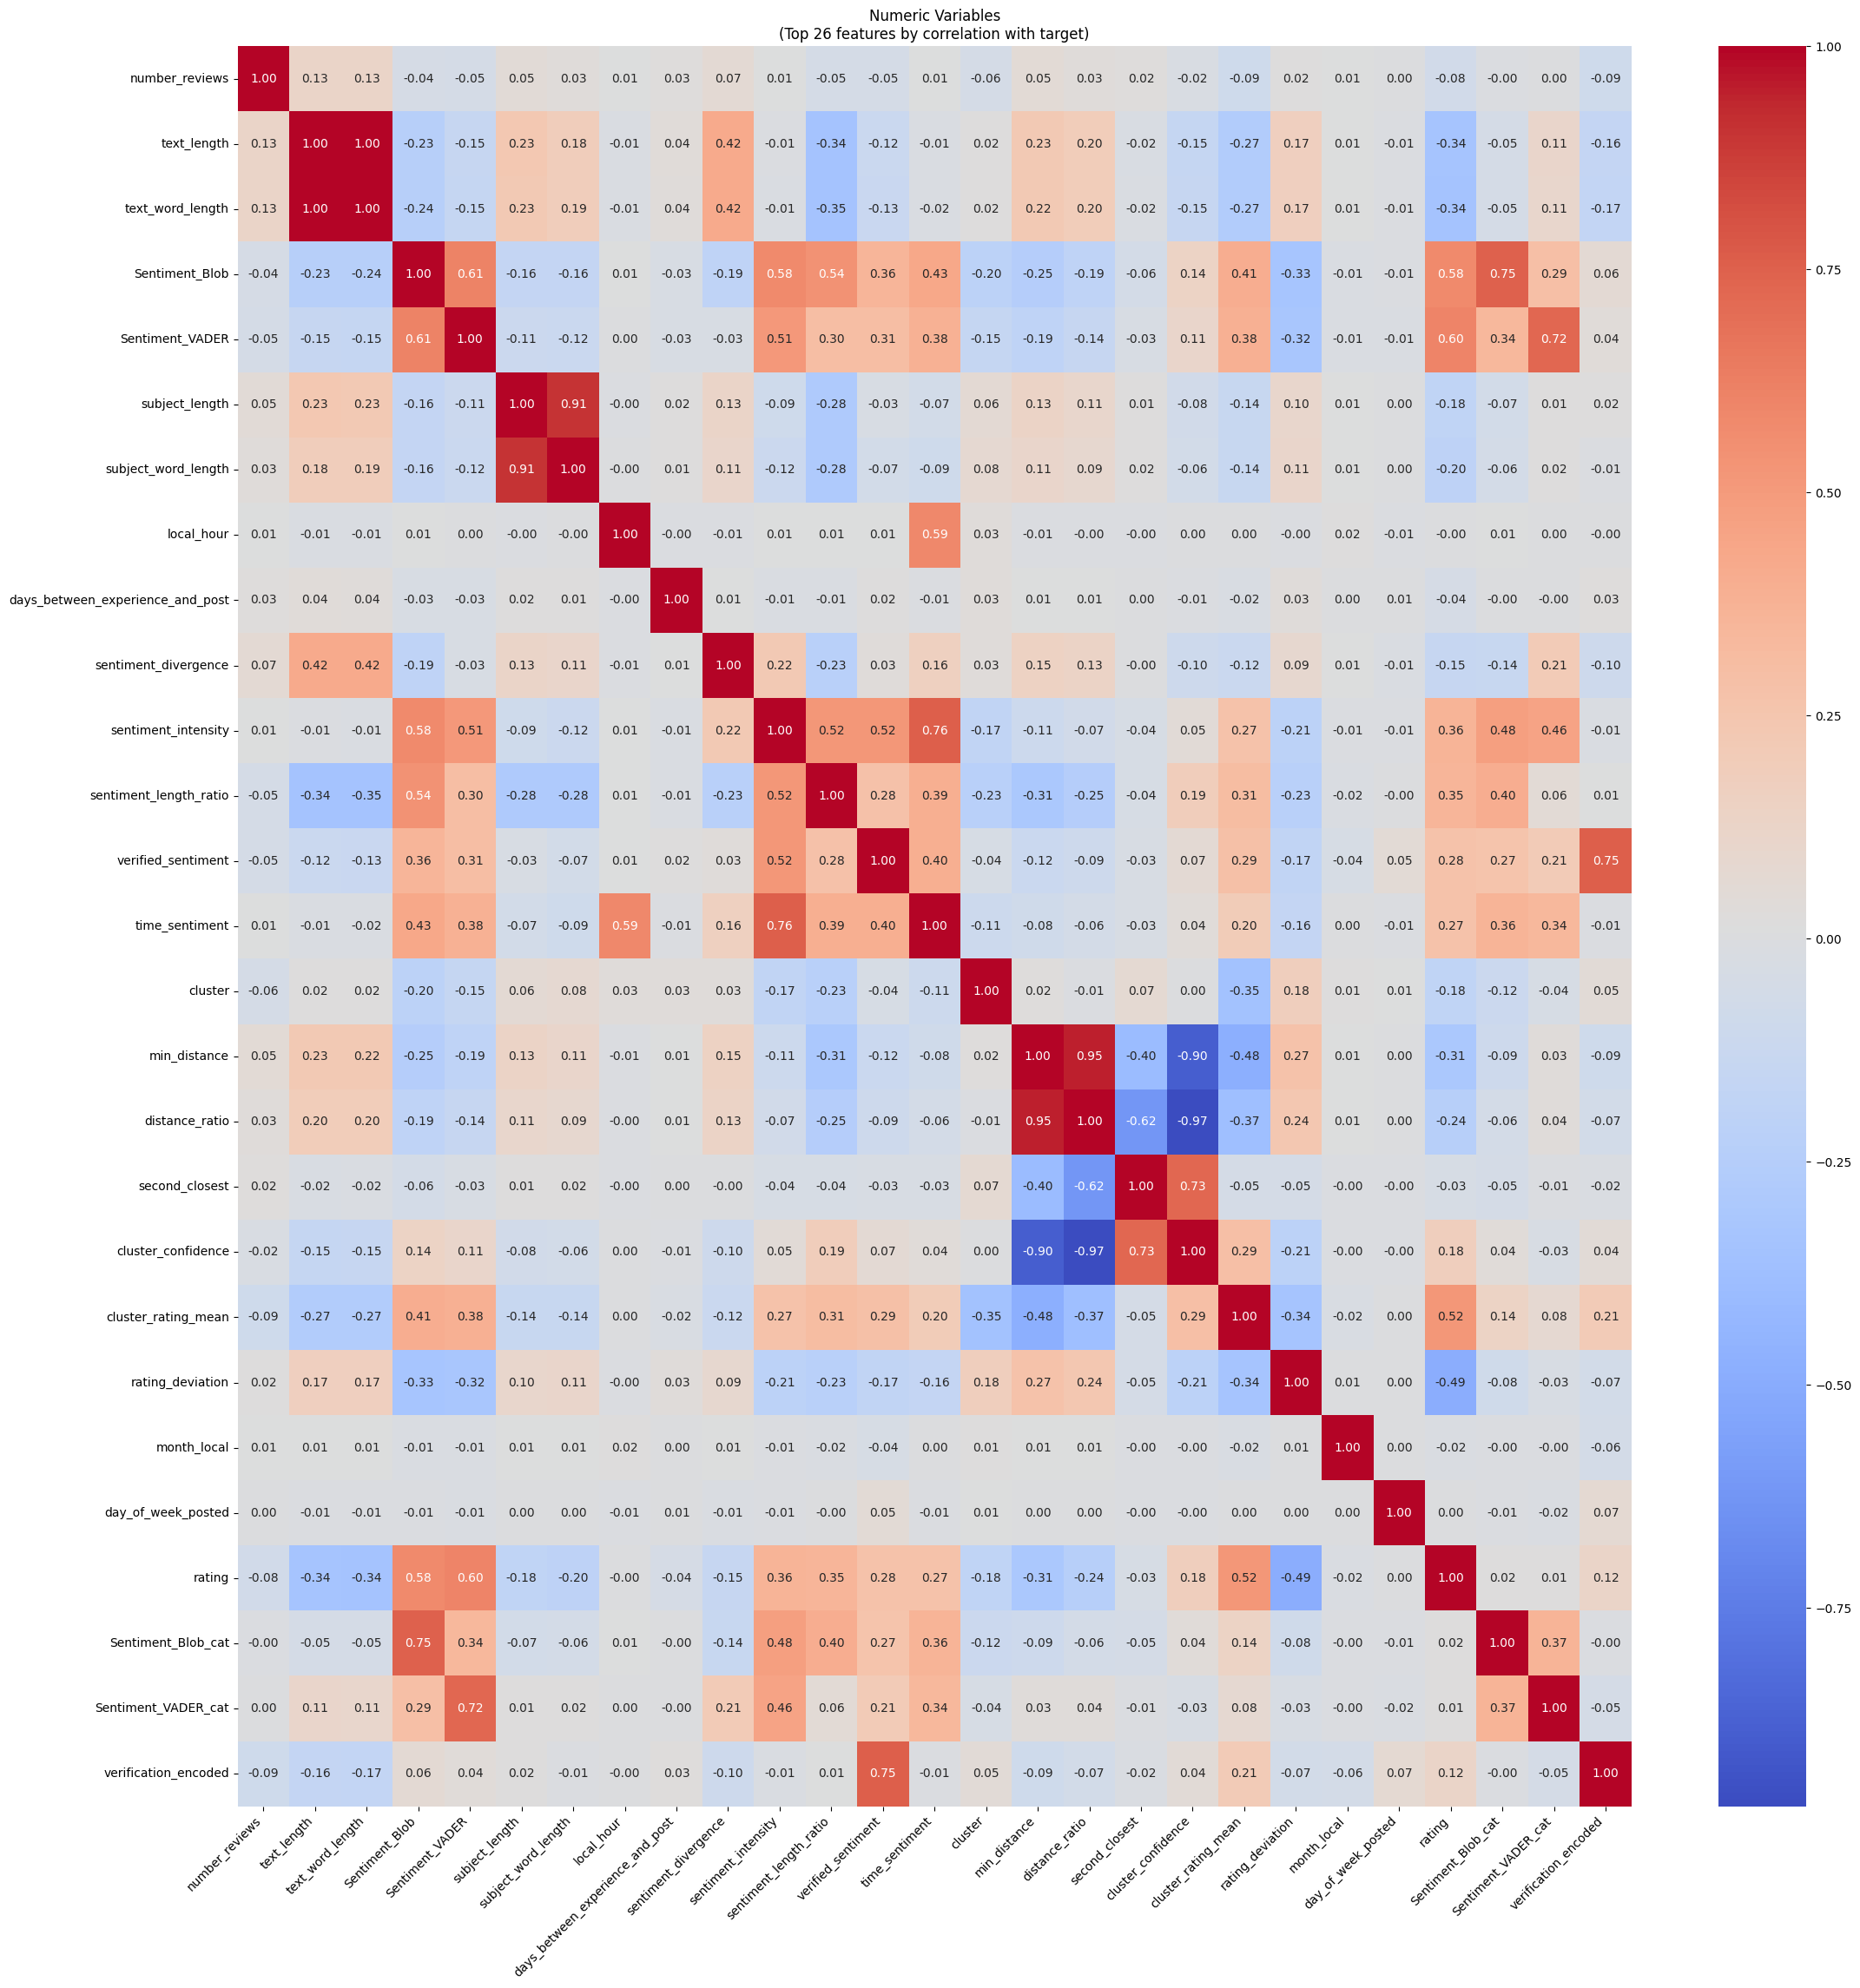

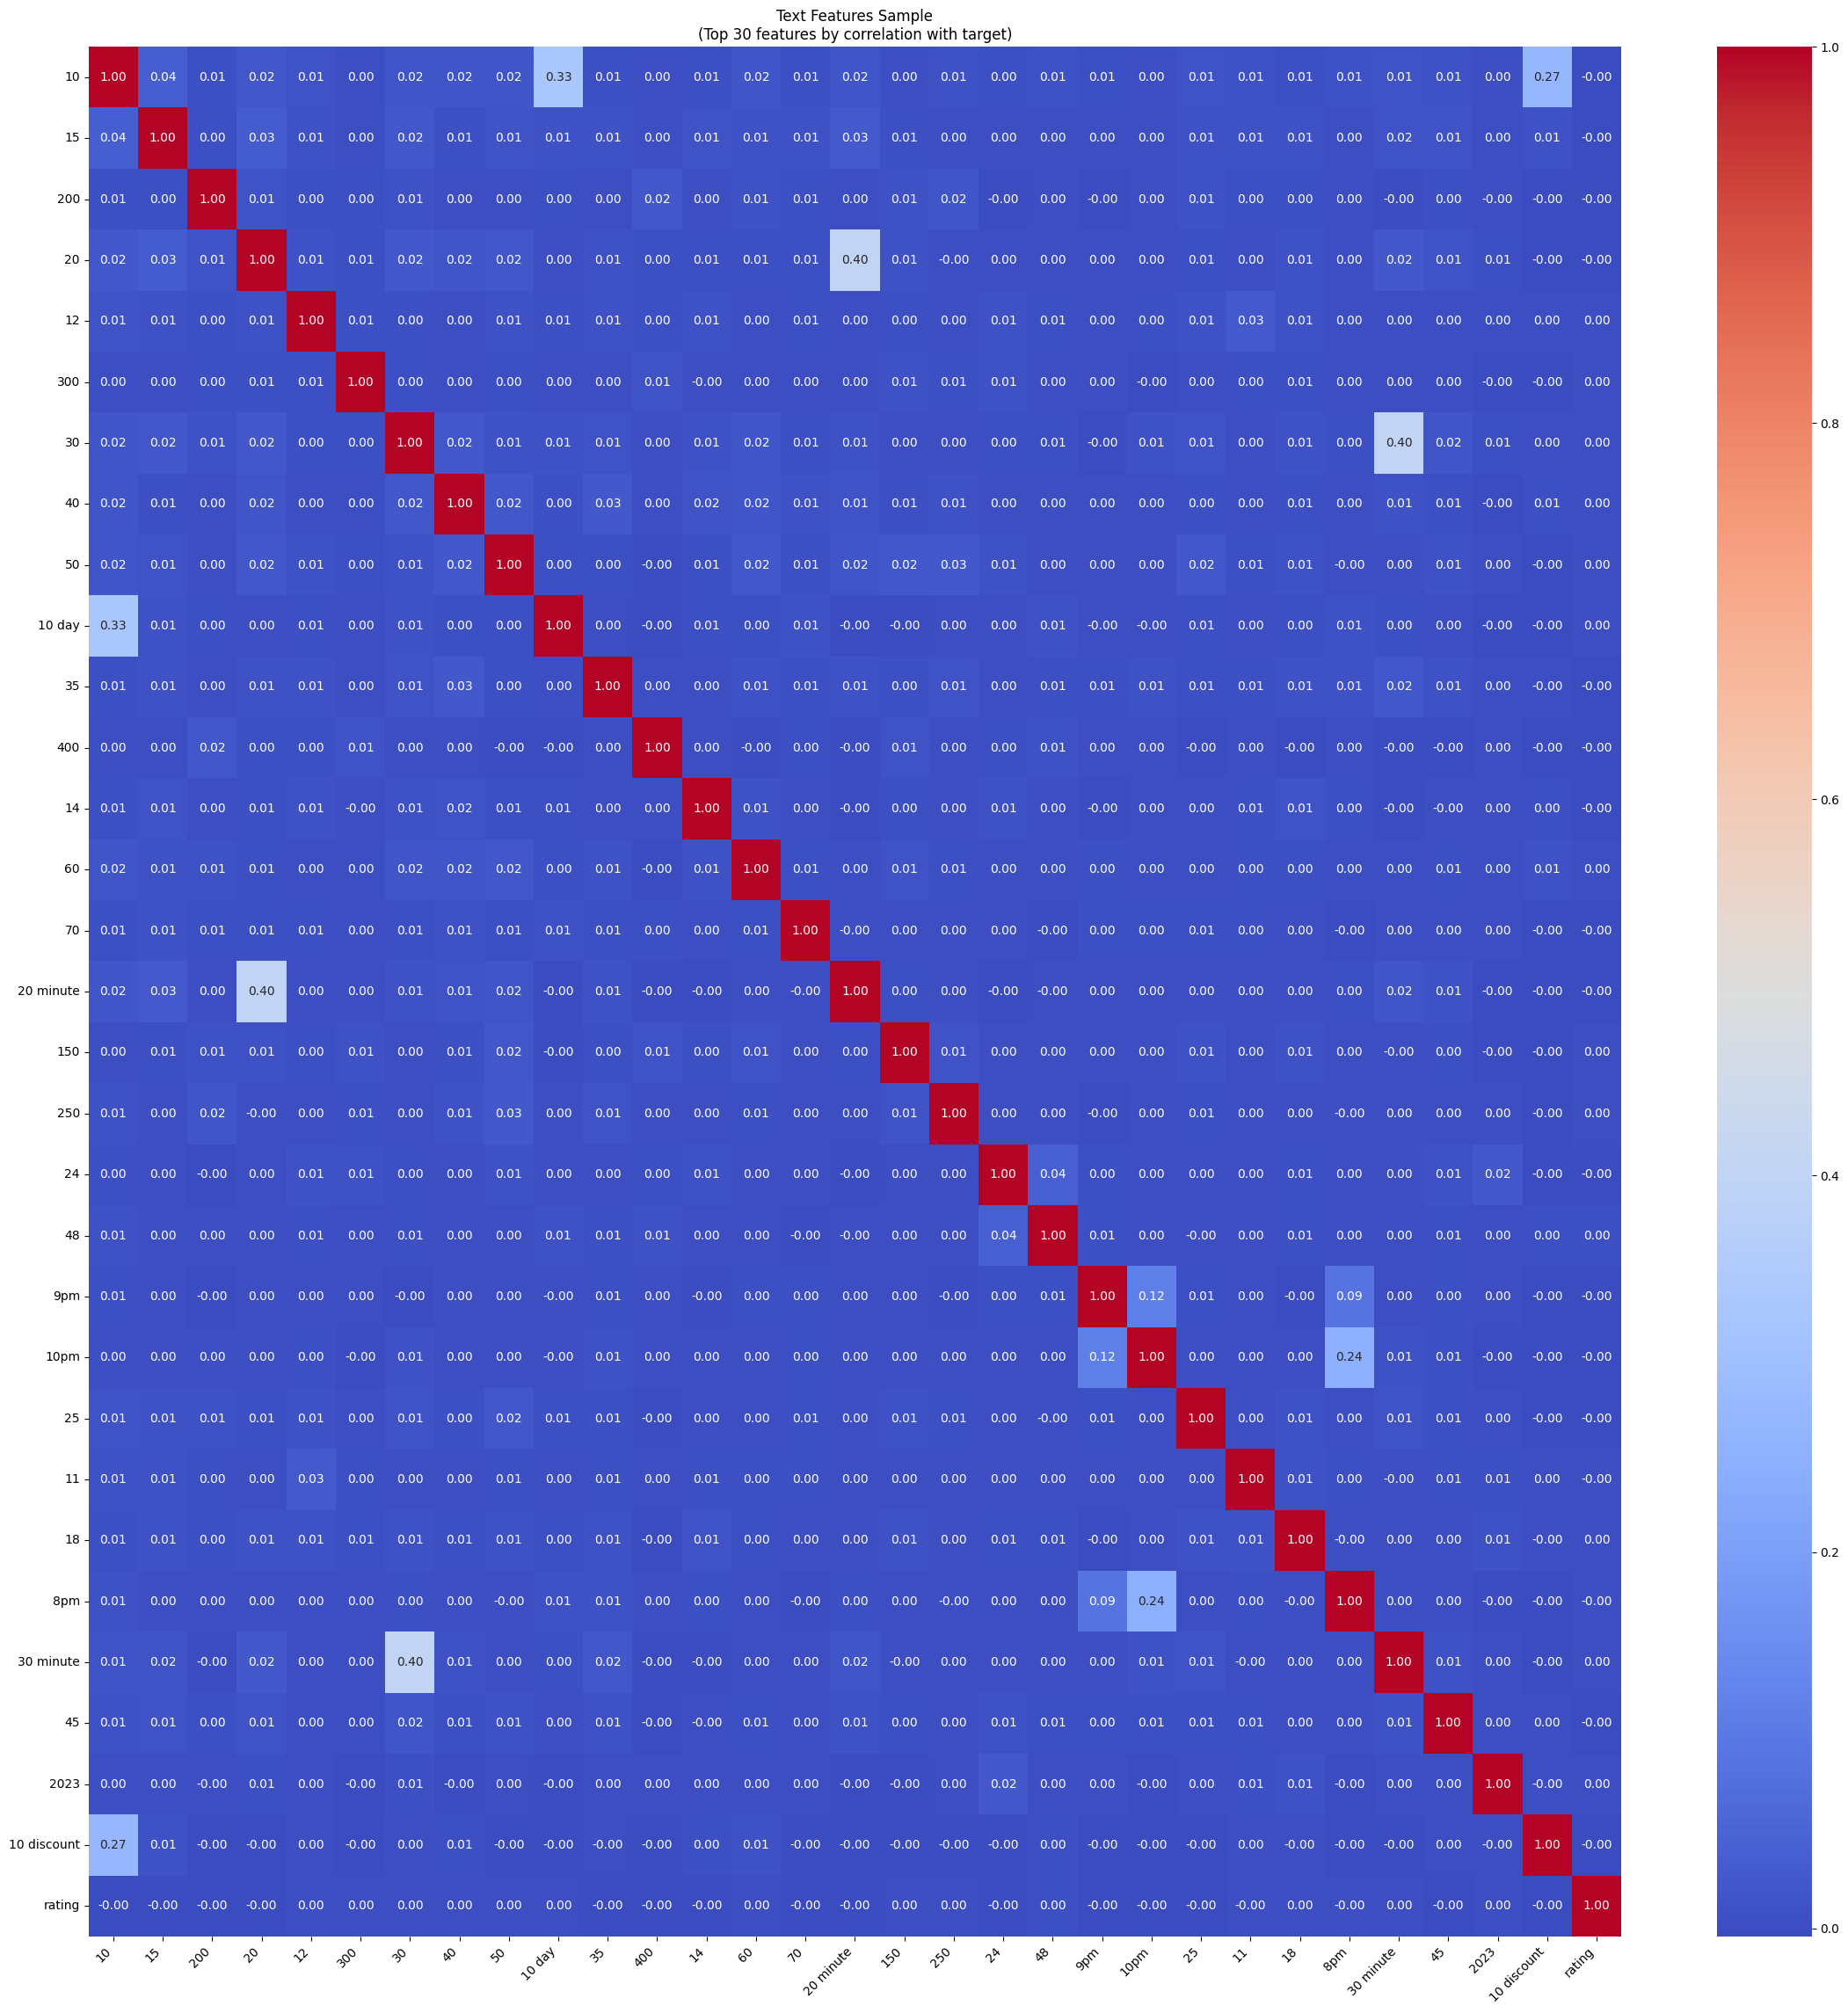

High correlations (>0.7):
Numeric Variables:
text_length & text_word_length: 0.996
Correlation with rating: text_length: 0.335, text_word_length: 0.343
Keep text_word_length

Sentiment_Blob & Sentiment_Blob_cat: 0.753
Correlation with rating: Sentiment_Blob: 0.579, Sentiment_Blob_cat: 0.020
Keep Sentiment_Blob

Sentiment_VADER & Sentiment_VADER_cat: 0.724
Correlation with rating: Sentiment_VADER: 0.600, Sentiment_VADER_cat: 0.014
Keep Sentiment_VADER

subject_length & subject_word_length: 0.906
Correlation with rating: subject_length: 0.182, subject_word_length: 0.197
Keep subject_word_length

sentiment_intensity & time_sentiment: 0.755
Correlation with rating: sentiment_intensity: 0.363, time_sentiment: 0.271
Keep sentiment_intensity

verified_sentiment & verification_encoded: 0.754
Correlation with rating: verified_sentiment: 0.276, verification_encoded: 0.123
Keep verified_sentiment

min_distance & distance_ratio: 0.953
Correlation with rating: min_distance: 0.308, distance_ratio: 0

In [51]:
#Creating heatmap
def create_correlation_heatmap(data, target, title, max_features=30):
    try:
        if issparse(data):
            data = pd.DataFrame(data.toarray())
            data.columns = [f'feature_{i}' for i in range(data.shape[1])]
        elif isinstance(data, pd.DataFrame):
            data = data.copy()
            data = data.sparse.to_dense() if hasattr(data, 'sparse') else data
            data = data.astype(float)
        data['rating'] = target
        if data.shape[1] > max_features + 1:
            corrs = [abs(np.corrcoef(data[col], target)[0,1]) for col in data.columns if col != 'rating']
            corrs_dict = dict(zip([col for col in data.columns if col != 'rating'], corrs))
            top_cols = sorted(corrs_dict.items(), key=lambda x: abs(x[1]), reverse=True)[:max_features]
            top_cols = [col[0] for col in top_cols]
            data = data[top_cols + ['rating']]
        corr_matrix = data.corr()
        plt.figure(figsize=(23, 23))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
        plt.title(f"{title}\n(Top {min(max_features, data.shape[1]-1)} features by correlation with target)")
        plt.xticks(rotation=45, ha='right')
        plt.subplots_adjust(bottom=0.2)
        plt.tight_layout()
        plt.show()
        return corr_matrix
    except Exception as e:
        print(f"Error in create_correlation_heatmap: {str(e)}")
        return None

max_text_features = 1000

try:
    numeric_for_correlation = train_df[categories['true_numeric'] + categories['time_based_numeric'] + categories['categorical_ordinal']]
    numeric_corr = create_correlation_heatmap(numeric_for_correlation, train_df['rating'], 'Numeric Variables')
except Exception as e:
    print(f"Error processing numeric correlations: {str(e)}")
    numeric_corr = None

try:
    text_features_correlations = pd.DataFrame(X_train_tfidf[:, :max_text_features].toarray(), 
        columns=tfidf_features[:max_text_features])
    text_target_corrs = [abs(np.corrcoef(text_features_correlations[col], train_df['rating'])[0,1]) 
        for col in text_features_correlations.columns]
    corr_dict = dict(zip(text_features_correlations.columns, text_target_corrs))
    top_features = sorted(corr_dict.items(), key=lambda x: abs(x[1]), reverse=True)[:30]
    text_sample = text_features_correlations[[col[0] for col in top_features]]
    text_corr = create_correlation_heatmap(text_sample, train_df['rating'], 'Text Features Sample')
except Exception as e:
    print(f"Error processing text correlations: {str(e)}")
    text_corr = None

def find_high_correlations(corr_matrix, threshold=0.7):
    if corr_matrix is None:
        return []
    high_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            try:
                corr = abs(corr_matrix.iloc[i, j].item())
                if corr > threshold:
                    var1 = corr_matrix.columns[i]
                    var2 = corr_matrix.columns[j]
                    rating_idx = corr_matrix.columns.get_loc('rating')
                    corr1 = abs(corr_matrix.iloc[i, rating_idx].item())
                    corr2 = abs(corr_matrix.iloc[j, rating_idx].item())
                    high_corr.append((var1, var2, corr, corr1, corr2))
            except (AttributeError, ValueError):
                continue
    return high_corr

print("High correlations (>0.7):")
for matrix, name in [(numeric_corr, "Numeric"), (text_corr, "Text")]:
    if matrix is not None:
        print(f"{name} Variables:")
        high_corr = find_high_correlations(matrix)
        for var1, var2, corr, corr1, corr2 in high_corr:
            if 'rating' not in (var1, var2):
                print(f"{var1} & {var2}: {corr:.3f}")
                print(f"Correlation with rating: {var1}: {corr1:.3f}, {var2}: {corr2:.3f}")
                print(f"Keep {var1 if corr1 > corr2 else var2}\n")

In [52]:
# Point-biserial correlation with binary features and'rating'
for binary_var in ['repeat_reviewer_encoded', 'answered_encoded', 'review_time_encoded']:
    corr, p_value = pointbiserialr(train_df[binary_var], train_df['rating'])
    print(f"{binary_var}: Point-biserial correlation with 'rating' = {corr:.3f} (p-value = {p_value:.3e})")

repeat_reviewer_encoded: Point-biserial correlation with 'rating' = -0.006 (p-value = 4.157e-03)
answered_encoded: Point-biserial correlation with 'rating' = -0.118 (p-value = 0.000e+00)
review_time_encoded: Point-biserial correlation with 'rating' = 0.009 (p-value = 1.872e-06)


STAGE 2 - ENCODING

In [53]:
def encode_features(train_df, test_df):
    time_of_day_order = ['Morning', 'Business Hours', 'Evening', 'Night']
    train_df['time_of_day_encoded'] = pd.Categorical(train_df['time_of_day'], categories=time_of_day_order).codes
    test_df['time_of_day_encoded'] = pd.Categorical(test_df['time_of_day'], categories=time_of_day_order).codes
    verification_order = ['Verified', 'Invited', 'Redirected', 'Not Verified']
    train_df['verification_encoded'] = pd.Categorical(train_df['verification'], categories=verification_order).codes
    test_df['verification_encoded'] = pd.Categorical(test_df['verification'], categories=verification_order).codes
    all_locations = pd.concat([train_df['location'], test_df['location']]).unique()
    location_map = {loc: idx for idx, loc in enumerate(sorted(all_locations))}
    train_df['location_encoded'] = train_df['location'].map(location_map)
    test_df['location_encoded'] = test_df['location'].map(location_map)
    
    for column in ['company', 'day_type']:
        train_df[f'{column}_encoded'] = pd.Categorical(train_df[column]).codes
        test_df[f'{column}_encoded'] = pd.Categorical(test_df[column]).codes
        
    return train_df, test_df
    
train_df, test_df = encode_features(train_df, test_df)

STAGE 3 - SCALE/NORMALIZE/STANDARDIZE

In [54]:
#Scaling and normalization
def scale_features(train_df, test_df, categories):
    standardize_columns = categories['true_numeric']
    normalize_columns = categories['categorical_ordinal']
    skip_columns = categories['binary_variables']
    
    std_scaler = StandardScaler()
    minmax_scaler = MinMaxScaler()
    
    if standardize_columns:
        train_df[[col + '_scaled' for col in standardize_columns]] = std_scaler.fit_transform(train_df[standardize_columns])
        test_df[[col + '_scaled' for col in standardize_columns]] = std_scaler.transform(test_df[standardize_columns])
    
    if normalize_columns:
        train_df[[col + '_normalized' for col in normalize_columns]] = minmax_scaler.fit_transform(train_df[normalize_columns])
        test_df[[col + '_normalized' for col in normalize_columns]] = minmax_scaler.transform(test_df[normalize_columns])
    
    print("Features skipped (binary):", skip_columns)
    print("Features to standardize:", standardize_columns)
    print("Features to normalize:", normalize_columns)
    
    return train_df, test_df, {'standard': std_scaler, 'minmax': minmax_scaler}

train_df, test_df, scalers = scale_features(train_df, test_df, categories)

print("Training set statistics after scaling:")
print("Standardized features:")
print(train_df[[col for col in train_df.columns if col.endswith('_scaled')]].describe())
print("Normalized features:")
print(train_df[[col for col in train_df.columns if col.endswith('_normalized')]].describe())

Features skipped (binary): ['repeat_reviewer', 'repeat_reviewer_encoded', 'answered_encoded', 'day_type', 'review_time', 'review_time_encoded', 'extreme_sentiment']
Features to standardize: ['number_reviews', 'text_length', 'text_word_length', 'Sentiment_Blob', 'Sentiment_VADER', 'subject_length', 'subject_word_length', 'local_hour', 'days_between_experience_and_post', 'sentiment_divergence', 'sentiment_intensity', 'sentiment_length_ratio', 'verified_sentiment', 'time_sentiment', 'cluster', 'min_distance', 'distance_ratio', 'second_closest', 'cluster_confidence', 'cluster_rating_mean', 'rating_deviation']
Features to normalize: ['rating', 'Sentiment_Blob_cat', 'Sentiment_VADER_cat', 'verification_encoded']
Training set statistics after scaling:
Standardized features:
       number_reviews_scaled  text_length_scaled  text_word_length_scaled  \
count           2.560390e+05        2.560390e+05             2.560390e+05   
mean            3.080400e-17        5.838884e-17            -6.18855

In [55]:
# Define statistical features and complete set of features
categories = categorize_columns(train_df)

statistical_features = (categories['binary_variables'] + categories['categorical_ordinal'] + categories['true_numeric'] + 
                       categories['time_based_numeric'])

full_set = (categories['binary_variables'] + categories['categorical_ordinal'] + categories['categorical_text'] + 
            categories['true_numeric'] + categories['time_based_numeric'] + categories['datetime_columns'])

print(f"Number of features in full set: {len(full_set)}")

Binary variables: ['repeat_reviewer', 'repeat_reviewer_encoded', 'answered_encoded', 'day_type', 'review_time', 'review_time_encoded', 'extreme_sentiment']
Categorical text: ['location', 'username', 'verification', 'company', 'text', 'text_processed', 'subject', 'subject_processed', 'answer', 'answer_processed', 'time_of_day', 'punctuation_counts']
Categorical ordinal: ['rating', 'Sentiment_Blob_cat', 'Sentiment_VADER_cat', 'verification_encoded', 'time_of_day_encoded', 'location_encoded', 'company_encoded', 'day_type_encoded', 'cluster_scaled', 'cluster_rating_mean_scaled', 'rating_normalized', 'Sentiment_Blob_cat_normalized', 'Sentiment_VADER_cat_normalized', 'verification_encoded_normalized']
True numeric: ['number_reviews', 'text_length', 'text_word_length', 'Sentiment_Blob', 'Sentiment_VADER', 'subject_length', 'subject_word_length', 'local_hour', 'days_between_experience_and_post', 'sentiment_divergence', 'sentiment_intensity', 'sentiment_length_ratio', 'verified_sentiment', 'tim

STAGE 4 - VARIANCE THRESHOLD

In [56]:
top_n_tfidf = 15
top_n_bow = 15
valid_indices = train_df['rating'].notna()
train_df_aligned = train_df[valid_indices].copy()
X_train_tfidf_aligned = X_train_tfidf[valid_indices]
X_train_bow_aligned = X_train_bow[valid_indices]
ratings = train_df_aligned['rating'].values
ratings_std = (ratings - np.mean(ratings)) / np.std(ratings)

def find_top_correlations_efficient(sparse_matrix, ratings_std, top_n=15, batch_size=1000):
    correlations = []
    if not sparse.isspmatrix_csc(sparse_matrix):
        sparse_matrix = sparse_matrix.tocsc()
    
    n_features = sparse_matrix.shape[1]
    for start_idx in range(0, n_features, batch_size):
        end_idx = min(start_idx + batch_size, n_features)
        batch = sparse_matrix[:, start_idx:end_idx]
        
        batch_mean = np.asarray(batch.mean(axis=0)).ravel()
        batch_std = np.sqrt(np.asarray(batch.power(2).mean(axis=0) - np.power(batch_mean, 2))).ravel()
        valid_features = batch_std != 0
        
        if np.any(valid_features):
            valid_cols = np.where(valid_features)[0]
            batch_data = batch[:, valid_cols].toarray()
            batch_standardized = (batch_data - batch_mean[valid_features]) / batch_std[valid_features]
            batch_correlations = np.sum(ratings_std[:, np.newaxis] * batch_standardized, axis=0) / len(ratings)
            
            for idx, corr in zip(valid_cols, batch_correlations):
                if not np.isnan(corr):
                    correlations.append((start_idx + idx, abs(corr)))
    
    correlations.sort(key=lambda x: x[1], reverse=True)
    return [idx for idx, _ in correlations[:top_n]]

top_tfidf_indices = find_top_correlations_efficient(X_train_tfidf_aligned, ratings_std, top_n_tfidf)
top_bow_indices = find_top_correlations_efficient(X_train_bow_aligned, ratings_std, top_n_bow)
top_tfidf_cols = [f"tfidf_{idx}" for idx in top_tfidf_indices]
top_bow_cols = [f"bow_{idx}" for idx in top_bow_indices]

def calculate_variance_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols):
    numeric_features = train_df[statistical_features].select_dtypes(include=['int64', 'float64']).columns
    regular_variances = dict(zip(numeric_features, train_df[numeric_features].var().values))
    tfidf_indices = [int(col.split('_')[1]) for col in top_tfidf_cols]
    tfidf_slice = X_train_tfidf[:, tfidf_indices]
    tfidf_variances = dict(zip(top_tfidf_cols, 
        np.asarray(tfidf_slice.power(2).mean(0) - np.power(tfidf_slice.mean(0), 2)).flatten()))
    bow_indices = [int(col.split('_')[1]) for col in top_bow_cols]
    bow_slice = X_train_bow[:, bow_indices]
    bow_variances = dict(zip(top_bow_cols, 
        np.asarray(bow_slice.power(2).mean(0) - np.power(bow_slice.mean(0), 2)).flatten()))
    return {**regular_variances, **tfidf_variances, **bow_variances}

variance_scores = calculate_variance_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols)

STAGE 5 - MEAN ABSOLUTE DIFFERENCE

In [57]:
tfidf_indices = [int(col.split('_')[1]) for col in top_tfidf_cols]
bow_indices = [int(col.split('_')[1]) for col in top_bow_cols]
X_train_tfidf = X_train_tfidf[:, tfidf_indices]
X_train_bow = X_train_bow[:, bow_indices]

def calculate_mad_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols):
    numeric_features = train_df[statistical_features].select_dtypes(include=['int64', 'float64']).columns
    regular_mad = {}
    for col in numeric_features:
        col_mean = train_df[col].mean()
        mad_value = np.mean(np.abs(train_df[col] - col_mean))
        regular_mad[col] = mad_value
    tfidf_slice = X_train_tfidf.toarray()
    tfidf_means = np.mean(tfidf_slice, axis=0)
    tfidf_mad = dict(zip(top_tfidf_cols, np.mean(np.abs(tfidf_slice - tfidf_means), axis=0)))
    bow_slice = X_train_bow.toarray()
    bow_means = np.mean(bow_slice, axis=0)
    bow_mad = dict(zip(top_bow_cols, np.mean(np.abs(bow_slice - bow_means), axis=0)))
    return {**regular_mad, **tfidf_mad, **bow_mad}

mad_scores = calculate_mad_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols)

In [58]:
#Data Leakage detection
def detect_leakage(train_df, test_df, checkpoint_name="", print_details=True):
    print(f"Shape of train_df: {train_df.shape if train_df is not None else 'None'}")
    print(f"Shape of test_df: {test_df.shape if test_df is not None else 'None'}")
    findings = {}
    has_leakage = False
    if print_details:
        print(f"Checking for leakage at checkpoint: {checkpoint_name}")
    if train_df is None or test_df is None:
        print("Error: train_df or test_df is None")
        return findings, has_leakage
    train_idx = set(train_df.index)
    test_idx = set(test_df.index)
    idx_overlap = train_idx.intersection(test_idx)
    findings['index_overlap'] = len(idx_overlap)
    if len(idx_overlap) > 0:
        has_leakage = True
        if print_details:
            print(f"WARNING: Found {len(idx_overlap)} overlapping indices")
            print(f"First 5 overlapping indices: {list(idx_overlap)[:5]}")
    if 'rating' in train_df.columns:
        train_features = train_df.drop('rating', axis=1)
        test_features = test_df.drop('rating', axis=1)
    else:
        train_features = train_df
        test_features = test_df
    common_columns = list(set(train_features.columns) & set(test_features.columns))
    numeric_columns = []
    for col in common_columns:
        if train_features[col].dtype in ['int64', 'float64', 'int32', 'float32']:
            numeric_columns.append(col)
    if common_columns:
        train_subset = train_features[common_columns]
        test_subset = test_features[common_columns]
        train_rows = set(map(tuple, train_subset.values))
        test_rows = set(map(tuple, test_subset.values))
        duplicate_rows = train_rows.intersection(test_rows)
        findings['duplicate_rows'] = len(duplicate_rows)
        if len(duplicate_rows) > 0:
            has_leakage = True
            if print_details:
                print(f"WARNING: Found {len(duplicate_rows)} duplicate rows between train and test")
    if 'rating' in train_df.columns and 'rating' in test_df.columns:
        train_dist = train_df['rating'].value_counts(normalize=True)
        test_dist = test_df['rating'].value_counts(normalize=True)
        dist_diff = abs(train_dist - test_dist).mean()
        findings['target_distribution_difference'] = dist_diff
    suspicious_features = []
    for col in numeric_columns:
        try:
            train_stats = train_features[col].agg(['mean', 'std', 'min', 'max'])
            test_stats = test_features[col].agg(['mean', 'std', 'min', 'max'])
            stats_similar = all(abs(float(train_stats[stat]) - float(test_stats[stat])) < 1e-10 
                for stat in ['mean', 'std', 'min', 'max'])
            if stats_similar:
                suspicious_features.append(col)
                has_leakage = True
        except (TypeError, ValueError):
            continue
    
    findings['suspicious_features'] = suspicious_features
    if suspicious_features and print_details:
        print(f"\nWARNING: Found {len(suspicious_features)} features with identical statistics:")
        print(suspicious_features)
    if print_details:
        print("\nLeakage Detection Summary:")
        print(f"Has leakage: {has_leakage}")
        print(f"Overlapping indices: {findings['index_overlap']}")
        print(f"Duplicate rows: {findings['duplicate_rows']}")
        print(f"Suspicious features: {len(findings['suspicious_features'])}")
        print("-" * 50)
    return findings, has_leakage

findings, has_leakage = detect_leakage(train_df, test_df)

Shape of train_df: (256039, 78)
Shape of test_df: (64010, 78)
Checking for leakage at checkpoint: 

Leakage Detection Summary:
Has leakage: False
Overlapping indices: 0
Duplicate rows: 0
Suspicious features: 0
--------------------------------------------------


STAGE 6 - PEARSON AND SPEARMAN

In [59]:
def calculate_correlation_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols):
    valid_indices = train_df['rating'].notna()
    train_df_aligned = train_df[valid_indices]
    ratings = train_df_aligned['rating'].values
    numeric_features = train_df[statistical_features].select_dtypes(include=['int64', 'float64']).columns
    correlations = {}
    for feature in numeric_features:
        values = train_df_aligned[feature].values
        pearson_coef, pearson_p = pearsonr(ratings, values)
        spearman_coef, spearman_p = spearmanr(ratings, values)
        correlations[feature] = {'pearson_coef': float(pearson_coef), 'pearson_p': float(pearson_p),
            'spearman_coef': float(spearman_coef), 'spearman_p': float(spearman_p)}
    tfidf_array = X_train_tfidf[valid_indices].toarray()
    for idx, feature in enumerate(top_tfidf_cols):
        values = tfidf_array[:, idx]
        pearson_coef, pearson_p = pearsonr(ratings, values)
        spearman_coef, spearman_p = spearmanr(ratings, values)
        correlations[feature] = {'pearson_coef': float(pearson_coef), 'pearson_p': float(pearson_p),
            'spearman_coef': float(spearman_coef), 'spearman_p': float(spearman_p)}
    bow_array = X_train_bow[valid_indices].toarray()
    for idx, feature in enumerate(top_bow_cols):
        values = bow_array[:, idx]
        pearson_coef, pearson_p = pearsonr(ratings, values)
        spearman_coef, spearman_p = spearmanr(ratings, values)
        correlations[feature] = {'pearson_coef': float(pearson_coef), 'pearson_p': float(pearson_p),
            'spearman_coef': float(spearman_coef), 'spearman_p': float(spearman_p)}
    return correlations

correlation_scores = calculate_correlation_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols)

STAGE 7 - ANOVA

In [60]:
def calculate_anova_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols):
    numeric_features = train_df[statistical_features].select_dtypes(include=['int64', 'float64']).columns
    anova_results = {}
    for feature in numeric_features:
        df_temp = pd.DataFrame({'feature_value': train_df[feature],  'rating': train_df['rating'].astype(int)})
        result = smf.ols('feature_value ~ rating', data=df_temp).fit()
        table = sm.stats.anova_lm(result)
        anova_results[feature] = {'f_stat': float(table['F'][0]), 'p_value': float(table['PR(>F)'][0])}
    tfidf_array = X_train_tfidf.toarray()
    for i, feature in enumerate(top_tfidf_cols):
        df_temp = pd.DataFrame({'feature_value': tfidf_array[:, i], 'rating': train_df['rating'].astype(int)})
        result = smf.ols('feature_value ~ rating', data=df_temp).fit()
        table = sm.stats.anova_lm(result)
        anova_results[feature] = {'f_stat': float(table['F'][0]), 'p_value': float(table['PR(>F)'][0])}
    bow_array = X_train_bow.toarray()
    for i, feature in enumerate(top_bow_cols):
        df_temp = pd.DataFrame({'feature_value': bow_array[:, i], 'rating': train_df['rating'].astype(int)})
        result = smf.ols('feature_value ~ rating', data=df_temp).fit()
        table = sm.stats.anova_lm(result)
        anova_results[feature] = {'f_stat': float(table['F'][0]), 'p_value': float(table['PR(>F)'][0])}
    return anova_results

anova_scores = calculate_anova_scores(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols)

STAGE 8 - MUTUAL INFORMATION

In [61]:
def calculate_mutual_info(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols):
    numeric_features = train_df[statistical_features].select_dtypes(include=['int64', 'float64']).columns
    ratings = train_df['rating'].values
    X = hstack([csr_matrix(train_df[numeric_features].values), X_train_tfidf, X_train_bow])
    importances = mutual_info_classif(X, ratings)
    all_columns = list(numeric_features) + top_tfidf_cols + top_bow_cols
    importances = importances / np.sum(importances)
    return dict(zip(all_columns, importances.astype(float)))

mi_scores = calculate_mutual_info(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols)

STAGE 9 - LASSO

In [62]:
def analyze_lasso_feature_selection(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols):
    valid_indices = train_df['rating'].notna()
    train_df_aligned = train_df[valid_indices].copy()
    X_train_tfidf_aligned = X_train_tfidf[valid_indices]
    X_train_bow_aligned = X_train_bow[valid_indices]
    if not (len(train_df_aligned) == X_train_tfidf_aligned.shape[0] == X_train_bow_aligned.shape[0]):
        raise ValueError(f"Misaligned data shapes after filtering: train_df={len(train_df_aligned)}, "
                       f"tfidf={X_train_tfidf_aligned.shape[0]}, bow={X_train_bow_aligned.shape[0]}")
    numeric_features = train_df_aligned[statistical_features].select_dtypes(include=['int64', 'float64']).columns
    X = train_df_aligned[numeric_features].copy()
    missing_cols = X.columns[X.isnull().any()].tolist()
    print("Columns with missing values before imputation:", missing_cols)

    for column in X.columns:
        if X[column].isnull().any():
            median_val = X[column].median()
            if pd.isna(median_val):  
                X[column] = X[column].fillna(0)
            else:
                X[column] = X[column].fillna(median_val)

    tfidf_array = X_train_tfidf_aligned[:, :len(top_tfidf_cols)].toarray()
    bow_array = X_train_bow_aligned[:, :len(top_bow_cols)].toarray()
    
    X = pd.concat([X, pd.DataFrame(tfidf_array, columns=top_tfidf_cols, index=X.index), pd.DataFrame(bow_array, columns=top_bow_cols, index=X.index)], axis=1)
    y = train_df_aligned['rating']
    X = X.fillna(0)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    alphas = np.logspace(-4, 1, 100)
    lasso = LassoCV(cv=5, random_state=42, max_iter=5000, alphas=alphas, selection='random', tol=1e-4)
    lasso.fit(X_scaled, y)
    lasso_coef = dict(zip(X.columns, lasso.coef_))
    lasso_coef = {k: float(v) for k, v in lasso_coef.items()}
    
    print(f"Best alpha: {lasso.alpha_:.6f}")
    non_zero_coef = {k: v for k, v in lasso_coef.items() if abs(v) > 1e-6}
    print(f"Number of features selected: {len(non_zero_coef)} out of {len(lasso_coef)}")
    
    for feature, coef in sorted(non_zero_coef.items(), key=lambda x: abs(x[1]), reverse=True):
        importance = ("strong" if abs(coef) >= 0.5 else
                     "moderate" if abs(coef) >= 0.1 else
                     "weak" if abs(coef) >= 0.01 else
                     "very weak")
        print(f"{feature}: {coef:.6f} ({importance})")
    
    return {'best_alpha': lasso.alpha_, 'coefficients': lasso_coef, 'n_selected': len(non_zero_coef)}

try:
    lasso_results = analyze_lasso_feature_selection(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols)
    lasso_coef = lasso_results['coefficients']
except Exception as e:
    print(f"Error during analysis: {str(e)}")
    lasso_coef = {}

Columns with missing values before imputation: []
Best alpha: 0.000100
Number of features selected: 12 out of 86
rating_normalized: 0.963453 (strong)
rating: 0.617020 (strong)
Sentiment_VADER_scaled: 0.180561 (moderate)
Sentiment_VADER: -0.180196 (moderate)
Sentiment_Blob_scaled: 0.112484 (moderate)
Sentiment_Blob: -0.112081 (moderate)
Sentiment_VADER_cat_normalized: -0.099755 (weak)
Sentiment_VADER_cat: 0.099292 (weak)
cluster_rating_mean: -0.020154 (weak)
cluster_rating_mean_scaled: 0.020050 (weak)
Sentiment_Blob_cat: -0.000073 (very weak)
Sentiment_Blob_cat_normalized: -0.000059 (very weak)


In [63]:
#Data Leakage detection
def detect_leakage(train_df, test_df, checkpoint_name="", print_details=True):
    print(f"Shape of train_df: {train_df.shape if train_df is not None else 'None'}")
    print(f"Shape of test_df: {test_df.shape if test_df is not None else 'None'}")
    findings = {}
    has_leakage = False
    if print_details:
        print(f"Checking for leakage at checkpoint: {checkpoint_name}")
    if train_df is None or test_df is None:
        print("Error: train_df or test_df is None")
        return findings, has_leakage
    train_idx = set(train_df.index)
    test_idx = set(test_df.index)
    idx_overlap = train_idx.intersection(test_idx)
    findings['index_overlap'] = len(idx_overlap)
    if len(idx_overlap) > 0:
        has_leakage = True
        if print_details:
            print(f"WARNING: Found {len(idx_overlap)} overlapping indices")
            print(f"First 5 overlapping indices: {list(idx_overlap)[:5]}")
    if 'rating' in train_df.columns:
        train_features = train_df.drop('rating', axis=1)
        test_features = test_df.drop('rating', axis=1)
    else:
        train_features = train_df
        test_features = test_df
    common_columns = list(set(train_features.columns) & set(test_features.columns))
    numeric_columns = []
    for col in common_columns:
        if train_features[col].dtype in ['int64', 'float64', 'int32', 'float32']:
            numeric_columns.append(col)
    if common_columns:
        train_subset = train_features[common_columns]
        test_subset = test_features[common_columns]
        train_rows = set(map(tuple, train_subset.values))
        test_rows = set(map(tuple, test_subset.values))
        duplicate_rows = train_rows.intersection(test_rows)
        findings['duplicate_rows'] = len(duplicate_rows)
        if len(duplicate_rows) > 0:
            has_leakage = True
            if print_details:
                print(f"WARNING: Found {len(duplicate_rows)} duplicate rows between train and test")
    if 'rating' in train_df.columns and 'rating' in test_df.columns:
        train_dist = train_df['rating'].value_counts(normalize=True)
        test_dist = test_df['rating'].value_counts(normalize=True)
        dist_diff = abs(train_dist - test_dist).mean()
        findings['target_distribution_difference'] = dist_diff
    suspicious_features = []
    for col in numeric_columns:
        try:
            train_stats = train_features[col].agg(['mean', 'std', 'min', 'max'])
            test_stats = test_features[col].agg(['mean', 'std', 'min', 'max'])
            stats_similar = all(abs(float(train_stats[stat]) - float(test_stats[stat])) < 1e-10 
                for stat in ['mean', 'std', 'min', 'max'])
            if stats_similar:
                suspicious_features.append(col)
                has_leakage = True
        except (TypeError, ValueError):
            continue
    
    findings['suspicious_features'] = suspicious_features
    if suspicious_features and print_details:
        print(f"\nWARNING: Found {len(suspicious_features)} features with identical statistics:")
        print(suspicious_features)
    if print_details:
        print("\nLeakage Detection Summary:")
        print(f"Has leakage: {has_leakage}")
        print(f"Overlapping indices: {findings['index_overlap']}")
        print(f"Duplicate rows: {findings['duplicate_rows']}")
        print(f"Suspicious features: {len(findings['suspicious_features'])}")
        print("-" * 50)
    return findings, has_leakage

findings, has_leakage = detect_leakage(train_df, test_df)

Shape of train_df: (256039, 78)
Shape of test_df: (64010, 78)
Checking for leakage at checkpoint: 

Leakage Detection Summary:
Has leakage: False
Overlapping indices: 0
Duplicate rows: 0
Suspicious features: 0
--------------------------------------------------


STAGE 10 - RANDOM FOREST IMPORTANCE

In [64]:
def analyze_random_forest_importance(train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols):
    valid_indices = train_df['rating'].notna()
    train_df_aligned = train_df[valid_indices].copy()
    X_train_tfidf_aligned = X_train_tfidf[valid_indices]
    X_train_bow_aligned = X_train_bow[valid_indices]
    if not (len(train_df_aligned) == X_train_tfidf_aligned.shape[0] == X_train_bow_aligned.shape[0]):
        raise ValueError(f"Misaligned data shapes after filtering: train_df={len(train_df_aligned)}, "
                       f"tfidf={X_train_tfidf_aligned.shape[0]}, bow={X_train_bow_aligned.shape[0]}")
    numeric_features = train_df_aligned[statistical_features].select_dtypes(include=['int64', 'float64']).columns
    X = train_df_aligned[numeric_features].fillna(0)
    tfidf_array = X_train_tfidf_aligned[:, :len(top_tfidf_cols)].toarray()
    tfidf_df = pd.DataFrame(tfidf_array, columns=top_tfidf_cols, index=X.index)
    X = pd.concat([X, tfidf_df], axis=1)
    bow_array = X_train_bow_aligned[:, :len(top_bow_cols)].toarray()
    bow_df = pd.DataFrame(bow_array, columns=top_bow_cols, index=X.index)
    X = pd.concat([X, bow_df], axis=1)
    y = train_df_aligned['rating']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)
    rf.fit(X_scaled, y)
    rf_importance = dict(zip(X.columns, rf.feature_importances_))
    rf_importance = {k: float(v) for k, v in rf_importance.items()}
    mean_importance = np.mean(list(rf_importance.values()))
    std_importance = np.std(list(rf_importance.values()))
    
    for feature, importance in sorted(rf_importance.items(), key=lambda x: x[1], reverse=True):
        if importance > mean_importance + std_importance:
            status = "Very Important"
        elif importance > mean_importance:
            status = "Important"
        elif importance < mean_importance - std_importance:
            status = "Consider Dropping"
        else:
            status = "Review"
        print(f"{feature}: {importance:.6f} ({status})")
    
    return {'mean_importance': float(mean_importance), 'std_importance': float(std_importance), 'importances': rf_importance}

try:
    rf_results = analyze_random_forest_importance(
        train_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols)
    rf_importance = rf_results['importances']
except Exception as e:
    print(f"Error during analysis: {str(e)}")
    rf_importance = {}

rating: 0.260247 (Very Important)
rating_normalized: 0.241900 (Very Important)
rating_deviation: 0.120803 (Very Important)
rating_deviation_scaled: 0.117982 (Very Important)
Sentiment_VADER_scaled: 0.026331 (Important)
Sentiment_Blob: 0.024082 (Important)
Sentiment_Blob_scaled: 0.022396 (Important)
cluster_rating_mean_scaled: 0.020354 (Important)
Sentiment_VADER: 0.019655 (Important)
cluster_rating_mean: 0.018627 (Important)
Sentiment_VADER_cat_normalized: 0.012674 (Important)
Sentiment_Blob_cat: 0.012338 (Important)
Sentiment_Blob_cat_normalized: 0.012278 (Important)
sentiment_length_ratio: 0.011899 (Important)
Sentiment_VADER_cat: 0.010820 (Review)
sentiment_length_ratio_scaled: 0.009286 (Review)
cluster_scaled: 0.007089 (Review)
sentiment_intensity: 0.006965 (Review)
extreme_sentiment: 0.005956 (Review)
sentiment_intensity_scaled: 0.004974 (Review)
cluster: 0.004712 (Review)
text_word_length_scaled: 0.003241 (Review)
text_word_length: 0.002090 (Review)
answered_encoded: 0.002085 (Re

In [65]:
#Data Leakage detection
def detect_leakage(train_df, test_df, checkpoint_name="", print_details=True):
    print(f"Shape of train_df: {train_df.shape if train_df is not None else 'None'}")
    print(f"Shape of test_df: {test_df.shape if test_df is not None else 'None'}")
    findings = {}
    has_leakage = False
    if print_details:
        print(f"Checking for leakage at checkpoint: {checkpoint_name}")
    if train_df is None or test_df is None:
        print("Error: train_df or test_df is None")
        return findings, has_leakage
    train_idx = set(train_df.index)
    test_idx = set(test_df.index)
    idx_overlap = train_idx.intersection(test_idx)
    findings['index_overlap'] = len(idx_overlap)
    if len(idx_overlap) > 0:
        has_leakage = True
        if print_details:
            print(f"WARNING: Found {len(idx_overlap)} overlapping indices")
            print(f"First 5 overlapping indices: {list(idx_overlap)[:5]}")
    if 'rating' in train_df.columns:
        train_features = train_df.drop('rating', axis=1)
        test_features = test_df.drop('rating', axis=1)
    else:
        train_features = train_df
        test_features = test_df
    common_columns = list(set(train_features.columns) & set(test_features.columns))
    numeric_columns = []
    for col in common_columns:
        if train_features[col].dtype in ['int64', 'float64', 'int32', 'float32']:
            numeric_columns.append(col)
    if common_columns:
        train_subset = train_features[common_columns]
        test_subset = test_features[common_columns]
        train_rows = set(map(tuple, train_subset.values))
        test_rows = set(map(tuple, test_subset.values))
        duplicate_rows = train_rows.intersection(test_rows)
        findings['duplicate_rows'] = len(duplicate_rows)
        if len(duplicate_rows) > 0:
            has_leakage = True
            if print_details:
                print(f"WARNING: Found {len(duplicate_rows)} duplicate rows between train and test")
    if 'rating' in train_df.columns and 'rating' in test_df.columns:
        train_dist = train_df['rating'].value_counts(normalize=True)
        test_dist = test_df['rating'].value_counts(normalize=True)
        dist_diff = abs(train_dist - test_dist).mean()
        findings['target_distribution_difference'] = dist_diff
    suspicious_features = []
    for col in numeric_columns:
        try:
            train_stats = train_features[col].agg(['mean', 'std', 'min', 'max'])
            test_stats = test_features[col].agg(['mean', 'std', 'min', 'max'])
            stats_similar = all(abs(float(train_stats[stat]) - float(test_stats[stat])) < 1e-10 
                for stat in ['mean', 'std', 'min', 'max'])
            if stats_similar:
                suspicious_features.append(col)
                has_leakage = True
        except (TypeError, ValueError):
            continue
    
    findings['suspicious_features'] = suspicious_features
    if suspicious_features and print_details:
        print(f"\nWARNING: Found {len(suspicious_features)} features with identical statistics:")
        print(suspicious_features)
    if print_details:
        print("\nLeakage Detection Summary:")
        print(f"Has leakage: {has_leakage}")
        print(f"Overlapping indices: {findings['index_overlap']}")
        print(f"Duplicate rows: {findings['duplicate_rows']}")
        print(f"Suspicious features: {len(findings['suspicious_features'])}")
        print("-" * 50)
    return findings, has_leakage

findings, has_leakage = detect_leakage(train_df, test_df)

Shape of train_df: (256039, 78)
Shape of test_df: (64010, 78)
Checking for leakage at checkpoint: 

Leakage Detection Summary:
Has leakage: False
Overlapping indices: 0
Duplicate rows: 0
Suspicious features: 0
--------------------------------------------------


STAGE 11 - FEATURE SELECTION

In [66]:
tfidf_indices = [int(col.split('_')[1]) for col in top_tfidf_cols]
bow_indices = [int(col.split('_')[1]) for col in top_bow_cols]

def integrate_features(train_df, test_df, X_train_tfidf, X_test_tfidf, X_train_bow, X_test_bow,
                      tfidf_indices, bow_indices):
    numeric_features = [col for col in train_df.select_dtypes(include=['int64', 'float64']).columns if col != 'rating']
    numeric_train = csr_matrix(train_df[numeric_features].values)
    numeric_test = csr_matrix(test_df[numeric_features].values)
    X_train_sparse = hstack([numeric_train, X_train_tfidf, X_train_bow])
    X_test_sparse = hstack([numeric_test, X_test_tfidf, X_test_bow])
    return X_train_sparse, X_test_sparse

X_train_sparse, X_test_sparse = integrate_features(train_df, test_df, X_train_tfidf, X_test_tfidf, X_train_bow, X_test_bow,
    tfidf_indices, bow_indices)

print(f"Train shape after integrating features: {X_train_sparse.shape}")
print(f"Test shape after integrating features: {X_test_sparse.shape}")
print("Verification:")
print(f"Number of TF-IDF features added: {len(top_tfidf_cols)}")
print(f"Number of BoW features added: {len(top_bow_cols)}")
print(f"Total number of features: {X_train_sparse.shape[1]}")

Train shape after integrating features: (256039, 85)
Test shape after integrating features: (64010, 100055)
Verification:
Number of TF-IDF features added: 15
Number of BoW features added: 15
Total number of features: 85


In [67]:
#Remove non-numeric columns
columns_to_drop = categorical_text + datetime_columns
train_df = train_df.drop(columns_to_drop, axis=1)
test_df = test_df.drop(columns_to_drop, axis=1)

print(f"Train shape after dropping text and date columns: {train_df.shape}")
print(f"Test shape after dropping text and date columns: {test_df.shape}")

Train shape after dropping text and date columns: (256039, 63)
Test shape after dropping text and date columns: (64010, 63)


In [68]:
#Data Leakage detection
def detect_leakage(train_df, test_df, checkpoint_name="", print_details=True):
    print(f"Shape of train_df: {train_df.shape if train_df is not None else 'None'}")
    print(f"Shape of test_df: {test_df.shape if test_df is not None else 'None'}")
    findings = {}
    has_leakage = False
    if print_details:
        print(f"Checking for leakage at checkpoint: {checkpoint_name}")
    if train_df is None or test_df is None:
        print("Error: train_df or test_df is None")
        return findings, has_leakage
    train_idx = set(train_df.index)
    test_idx = set(test_df.index)
    idx_overlap = train_idx.intersection(test_idx)
    findings['index_overlap'] = len(idx_overlap)
    if len(idx_overlap) > 0:
        has_leakage = True
        if print_details:
            print(f"WARNING: Found {len(idx_overlap)} overlapping indices")
            print(f"First 5 overlapping indices: {list(idx_overlap)[:5]}")
    if 'rating' in train_df.columns:
        train_features = train_df.drop('rating', axis=1)
        test_features = test_df.drop('rating', axis=1)
    else:
        train_features = train_df
        test_features = test_df
    common_columns = list(set(train_features.columns) & set(test_features.columns))
    numeric_columns = []
    for col in common_columns:
        if train_features[col].dtype in ['int64', 'float64', 'int32', 'float32']:
            numeric_columns.append(col)
    if common_columns:
        train_subset = train_features[common_columns]
        test_subset = test_features[common_columns]
        train_rows = set(map(tuple, train_subset.values))
        test_rows = set(map(tuple, test_subset.values))
        duplicate_rows = train_rows.intersection(test_rows)
        findings['duplicate_rows'] = len(duplicate_rows)
        if len(duplicate_rows) > 0:
            has_leakage = True
            if print_details:
                print(f"WARNING: Found {len(duplicate_rows)} duplicate rows between train and test")
    if 'rating' in train_df.columns and 'rating' in test_df.columns:
        train_dist = train_df['rating'].value_counts(normalize=True)
        test_dist = test_df['rating'].value_counts(normalize=True)
        dist_diff = abs(train_dist - test_dist).mean()
        findings['target_distribution_difference'] = dist_diff
    suspicious_features = []
    for col in numeric_columns:
        try:
            train_stats = train_features[col].agg(['mean', 'std', 'min', 'max'])
            test_stats = test_features[col].agg(['mean', 'std', 'min', 'max'])
            stats_similar = all(abs(float(train_stats[stat]) - float(test_stats[stat])) < 1e-10 
                for stat in ['mean', 'std', 'min', 'max'])
            if stats_similar:
                suspicious_features.append(col)
                has_leakage = True
        except (TypeError, ValueError):
            continue
    
    findings['suspicious_features'] = suspicious_features
    if suspicious_features and print_details:
        print(f"\nWARNING: Found {len(suspicious_features)} features with identical statistics:")
        print(suspicious_features)
    if print_details:
        print("\nLeakage Detection Summary:")
        print(f"Has leakage: {has_leakage}")
        print(f"Overlapping indices: {findings['index_overlap']}")
        print(f"Duplicate rows: {findings['duplicate_rows']}")
        print(f"Suspicious features: {len(findings['suspicious_features'])}")
    return findings, has_leakage

findings, has_leakage = detect_leakage(train_df, test_df)

Shape of train_df: (256039, 63)
Shape of test_df: (64010, 63)
Checking for leakage at checkpoint: 

Leakage Detection Summary:
Has leakage: False
Overlapping indices: 0
Duplicate rows: 0
Suspicious features: 0


STAGE 12 - MULTICOLLINEARITY CHECK

In [69]:
def protect_target_variable(feature_list, target_col='rating'):
    protected_features = [f for f in feature_list if f != target_col]
    if len(protected_features) != len(feature_list):
        print(f"Warning: Target variable {target_col} was found in feature list and removed")
    return protected_features

In [70]:
#Multicollinearity Check and Removal
def check_multicollinearity(train_df, test_df, X_train_tfidf, X_train_bow, 
                           top_tfidf_cols, top_bow_cols, target_col='rating', threshold=0.7):
    target_related_patterns = ['rating', 'cluster_rating']
    features_to_exclude = [col for col in train_df.columns 
                          if any(pattern in col for pattern in target_related_patterns)]
    train_df = train_df.drop(columns=features_to_exclude, errors='ignore')
    test_df = test_df.drop(columns=features_to_exclude, errors='ignore')
    numeric_features = train_df.select_dtypes(include=['int64', 'float64']).columns
    numeric_features = [col for col in numeric_features if col != target_col]
    X_train = train_df[numeric_features].copy()
    if len(top_tfidf_cols) > 0:
        tfidf_array = X_train_tfidf.toarray()
        X_train = pd.concat([X_train, pd.DataFrame(tfidf_array, columns=top_tfidf_cols)], axis=1)
    if len(top_bow_cols) > 0:
        bow_array = X_train_bow.toarray()
        X_train = pd.concat([X_train, pd.DataFrame(bow_array, columns=top_bow_cols)], axis=1)
    corr_matrix = X_train.corr()
    
    def determine_feature_to_keep(feat1, feat2):
        if feat1 == feat2:
            return None, None, "Self-correlation"
        base_feat1 = feat1.replace('_scaled', '').replace('_normalized', '').replace('_cat', '')
        base_feat2 = feat2.replace('_scaled', '').replace('_normalized', '').replace('_cat', '')
        if base_feat1 == base_feat2:
            if '_cat' in feat2 or '_cat' in feat1:
                non_cat = feat1 if '_cat' not in feat1 else feat2
                cat = feat2 if '_cat' in feat2 else feat1
                return non_cat, cat, "Keep original version over categorical"
            if '_normalized' in feat1: return feat1, feat2, "Keep normalized version"
            if '_normalized' in feat2: return feat2, feat1, "Keep normalized version"
            if '_scaled' in feat1: return feat1, feat2, "Keep scaled version"
            if '_scaled' in feat2: return feat2, feat1, "Keep scaled version"
        if (feat1.startswith('tfidf_') and feat2.startswith('bow_')) or \
           (feat2.startswith('tfidf_') and feat1.startswith('bow_')):
            tfidf_feat = feat1 if feat1.startswith('tfidf_') else feat2
            return tfidf_feat, (feat2 if feat1 == tfidf_feat else feat1), "Keep TF-IDF over BOW"
        return feat1, feat2, "Arbitrary choice for highly correlated features"
    
    high_correlations = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if i == j:
                continue
            correlation = abs(corr_matrix.iloc[i, j])
            if correlation > threshold:
                feat1 = corr_matrix.columns[i]
                feat2 = corr_matrix.columns[j]
                keep, drop, reason = determine_feature_to_keep(feat1, feat2)
                if keep and drop:
                    high_correlations.append({'Feature1': feat1, 'Feature2': feat2, 'Correlation': correlation,
                        'Keep': keep, 'Drop': drop, 'Reason': reason})
    
    if high_correlations:
        results = pd.DataFrame(high_correlations).sort_values('Correlation', ascending=False)
        features_to_drop = set(results['Drop'])
        print(f"\nRecommended features to drop ({len(features_to_drop)}):")
        for feature in sorted(features_to_drop):
            row = results[results['Drop'] == feature].iloc[0]
            print(f"- Drop {feature} (correlates with {row['Keep']}, reason: {row['Reason']})")
        recommended_features = [f for f in X_train.columns if f not in features_to_drop]  
        return results, recommended_features, X_train.columns.tolist()  
    else:
        print("No high correlations found among the features.")
        return None, X_train.columns.tolist(), X_train.columns.tolist() 

def remove_multicollinear_features(train_df, test_df, X_train_tfidf, X_train_bow, 
                                 top_tfidf_cols, top_bow_cols, target_col='rating'):
    try:
        train_indices = train_df.index
        test_indices = test_df.index
        correlation_results, recommended_features, all_features = check_multicollinearity(
            train_df, test_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols, target_col=target_col)
        if correlation_results is not None:
            features_to_drop = set(correlation_results['Drop'])
            features_to_drop = [f for f in features_to_drop if f in train_df.columns]
            train_df_cleaned = train_df.loc[train_indices].drop(features_to_drop, axis=1)
            test_df_cleaned = test_df.loc[test_indices].drop(features_to_drop, axis=1)
            print(f"Train shape after dropping correlated features: {train_df_cleaned.shape}")
            print(f"Test shape after dropping correlated features: {test_df_cleaned.shape}")
            train_features = [col for col in train_df_cleaned.columns if col != target_col]
            train_tuples = set(map(tuple, train_df_cleaned[train_features].values))
            test_tuples = set(map(tuple, test_df_cleaned[train_features].values))
            duplicates = train_tuples.intersection(test_tuples)
            
            if duplicates:
                print(f"\nFound {len(duplicates)} duplicate rows between train and test")
                test_mask = ~test_df_cleaned[train_features].apply(tuple, axis=1).isin(duplicates)
                test_df_cleaned = test_df_cleaned[test_mask]
                print(f"After removing duplicates - Train: {train_df_cleaned.shape}, Test: {test_df_cleaned.shape}")
            
            return train_df_cleaned, test_df_cleaned
        else:
            print("No highly correlated features to drop")
            return train_df, test_df
            
    except Exception as e:
        print(f"Error in multicollinearity check: {str(e)}")
        print("Returning original DataFrames without changes")
        return train_df, test_df

train_df, test_df = remove_multicollinear_features(train_df, test_df, X_train_tfidf, X_train_bow, top_tfidf_cols, top_bow_cols)




Recommended features to drop (46):
- Drop Sentiment_Blob (correlates with Sentiment_Blob_scaled, reason: Keep scaled version)
- Drop Sentiment_Blob_cat (correlates with Sentiment_Blob, reason: Keep original version over categorical)
- Drop Sentiment_Blob_cat_normalized (correlates with Sentiment_Blob_cat_normalized, reason: Keep original version over categorical)
- Drop Sentiment_VADER (correlates with Sentiment_VADER_scaled, reason: Keep scaled version)
- Drop Sentiment_VADER_cat (correlates with Sentiment_VADER_scaled, reason: Keep original version over categorical)
- Drop Sentiment_VADER_cat_normalized (correlates with Sentiment_VADER_cat_normalized, reason: Keep original version over categorical)
- Drop bow_11037 (correlates with tfidf_11037, reason: Keep TF-IDF over BOW)
- Drop bow_11969 (correlates with tfidf_11969, reason: Keep TF-IDF over BOW)
- Drop bow_12631 (correlates with tfidf_12631, reason: Keep TF-IDF over BOW)
- Drop bow_13025 (correlates with tfidf_13025, reason: Kee

In [71]:
#Data Leakage detection
def detect_leakage(train_df, test_df, checkpoint_name="", print_details=True):
    print(f"Shape of train_df: {train_df.shape if train_df is not None else 'None'}")
    print(f"Shape of test_df: {test_df.shape if test_df is not None else 'None'}")
    findings = {}
    has_leakage = False
    if print_details:
        print(f"Checking for leakage at checkpoint: {checkpoint_name}")
    if train_df is None or test_df is None:
        print("Error: train_df or test_df is None")
        return findings, has_leakage
    train_idx = set(train_df.index)
    test_idx = set(test_df.index)
    idx_overlap = train_idx.intersection(test_idx)
    findings['index_overlap'] = len(idx_overlap)
    if len(idx_overlap) > 0:
        has_leakage = True
        if print_details:
            print(f"WARNING: Found {len(idx_overlap)} overlapping indices")
            print(f"First 5 overlapping indices: {list(idx_overlap)[:5]}")
    if 'rating' in train_df.columns:
        train_features = train_df.drop('rating', axis=1)
        test_features = test_df.drop('rating', axis=1)
    else:
        train_features = train_df
        test_features = test_df
    common_columns = list(set(train_features.columns) & set(test_features.columns))
    numeric_columns = []
    for col in common_columns:
        if train_features[col].dtype in ['int64', 'float64', 'int32', 'float32']:
            numeric_columns.append(col)
    if common_columns:
        train_subset = train_features[common_columns]
        test_subset = test_features[common_columns]
        train_rows = set(map(tuple, train_subset.values))
        test_rows = set(map(tuple, test_subset.values))
        duplicate_rows = train_rows.intersection(test_rows)
        findings['duplicate_rows'] = len(duplicate_rows)
        if len(duplicate_rows) > 0:
            has_leakage = True
            if print_details:
                print(f"WARNING: Found {len(duplicate_rows)} duplicate rows between train and test")
    if 'rating' in train_df.columns and 'rating' in test_df.columns:
        train_dist = train_df['rating'].value_counts(normalize=True)
        test_dist = test_df['rating'].value_counts(normalize=True)
        dist_diff = abs(train_dist - test_dist).mean()
        findings['target_distribution_difference'] = dist_diff
    suspicious_features = []
    for col in numeric_columns:
        try:
            train_stats = train_features[col].agg(['mean', 'std', 'min', 'max'])
            test_stats = test_features[col].agg(['mean', 'std', 'min', 'max'])
            stats_similar = all(abs(float(train_stats[stat]) - float(test_stats[stat])) < 1e-10 
                for stat in ['mean', 'std', 'min', 'max'])
            if stats_similar:
                suspicious_features.append(col)
                has_leakage = True
        except (TypeError, ValueError):
            continue
    
    findings['suspicious_features'] = suspicious_features
    if suspicious_features and print_details:
        print(f"\nWARNING: Found {len(suspicious_features)} features with identical statistics:")
        print(suspicious_features)
    if print_details:
        print("\nLeakage Detection Summary:")
        print(f"Has leakage: {has_leakage}")
        print(f"Overlapping indices: {findings['index_overlap']}")
        print(f"Duplicate rows: {findings['duplicate_rows']}")
        print(f"Suspicious features: {len(findings['suspicious_features'])}")
    return findings, has_leakage

findings, has_leakage = detect_leakage(train_df, test_df)

Shape of train_df: (256039, 29)
Shape of test_df: (63932, 29)
Checking for leakage at checkpoint: 

Leakage Detection Summary:
Has leakage: False
Overlapping indices: 0
Duplicate rows: 0
Suspicious features: 0


In [72]:
def verify_feature_selection_integrity(X_train, X_test, y_train, y_test):
    integrity_checks = {'train_test_overlap': len(set(X_train.index) & set(X_test.index)) == 0,
        'feature_consistency': set(X_train.columns) == set(X_test.columns),
        'target_separation': all(y_train.index.isin(X_train.index)) and all(y_test.index.isin(X_test.index)),
        'shape_consistency': len(X_train) == len(y_train) and len(X_test) == len(y_test)}
    for check_name, passed in integrity_checks.items():
        if not passed:
            print(f"WARNING: Failed integrity check: {check_name}")
            if check_name == 'feature_consistency':
                print("Train features:", X_train.columns.tolist())
                print("Test features:", X_test.columns.tolist())
                print("Difference:", set(X_train.columns) ^ set(X_test.columns))
    return all(integrity_checks.values())

def create_clean_split(train_df, test_df):
    features = [col for col in train_df.columns if col != 'rating']
    train_tuples = set(map(tuple, train_df[features].values))
    test_tuples = set(map(tuple, test_df[features].values))
    duplicates = train_tuples.intersection(test_tuples)
    test_mask = ~test_df[features].apply(tuple, axis=1).isin(duplicates)
    test_df_clean = test_df[test_mask].copy()
    X_train = train_df[features]
    y_train = train_df['rating']
    X_test = test_df_clean[features]
    y_test = test_df_clean['rating']
    print(f"Original shapes - Train: {train_df.shape}, Test: {test_df.shape}")
    print(f"After duplicate removal - Train: {X_train.shape}, Test: {X_test.shape}")
    print(f"Removed {len(duplicates)} duplicate rows from test set")
    return X_train, X_test, y_train, y_test

def perform_feature_selection(train_df, test_df, variance_scores, mad_scores, correlation_scores,
                            anova_scores, mi_scores, lasso_coef, rf_importance):
    y_train = train_df['rating'].copy()
    y_test = test_df['rating'].copy()
    target_related_columns = ['rating', 'rating_normalized', 'cluster_rating_mean_scaled', 
        'rating_deviation_scaled', 'cluster_rating_mean', 'rating_deviation',
        'cluster_mean', 'cluster_std', 'cluster_median', 'cluster_size', 'cluster_rating', 'rating_std', 'rating_mean']
    
    train_features = train_df.drop(columns=[col for col in target_related_columns 
                                          if col in train_df.columns])
    test_features = test_df.drop(columns=[col for col in target_related_columns 
                                        if col in test_df.columns])

    global X_train_final, X_test_final, y_train_final, y_test_final, selected_features_final
    if 'Unnamed: 0' in train_df.columns:
        train_df = train_df.drop('Unnamed: 0', axis=1)
        test_df = test_df.drop('Unnamed: 0', axis=1)
    numeric_features = train_features.select_dtypes(include=['int64', 'float64']).columns
    available_features = numeric_features 
    feature_votes = pd.DataFrame(index=available_features)
    filtered_variance_scores = {k: v for k, v in variance_scores.items() if k in available_features}
    filtered_mad_scores = {k: v for k, v in mad_scores.items() if k in available_features}
    summary_table = pd.DataFrame(index=available_features)
    summary_table['Variance'] = pd.Series(filtered_variance_scores)
    summary_table['MAD'] = pd.Series(filtered_mad_scores)
    summary_table['Pearson Correlation'] = [abs(correlation_scores.get(col, {}).get('pearson_coef', 0))
                                          for col in available_features]
    summary_table['ANOVA F-stat'] = [anova_scores.get(col, {}).get('f_stat', 0)
                                    for col in available_features]
    summary_table['Mutual Info'] = [mi_scores.get(col, 0) for col in available_features]
    summary_table['Lasso Coefficient'] = [abs(lasso_coef.get(col, 0)) for col in available_features]
    summary_table['RF Importance'] = [rf_importance.get(col, 0) for col in available_features]
    
    feature_votes['variance'] = summary_table['Variance'] > summary_table['Variance'].median()
    feature_votes['mad'] = summary_table['MAD'] > summary_table['MAD'].median()
    feature_votes['correlation'] = summary_table['Pearson Correlation'].abs() > 0.1
    feature_votes['anova'] = [anova_scores.get(col, {}).get('p_value', 1) < 0.05 for col in available_features]
    feature_votes['mutual_info'] = summary_table['Mutual Info'] > summary_table['Mutual Info'].median()
    feature_votes['lasso'] = summary_table['Lasso Coefficient'].abs() > 0.01
    feature_votes['rf'] = summary_table['RF Importance'] > summary_table['RF Importance'].median()
    
    vote_counts = feature_votes.sum(axis=1)
    summary_table['Total Votes'] = vote_counts
    selected_features = vote_counts[vote_counts >= 4].index.tolist()
    summary_table['Selected'] = summary_table.index.isin(selected_features)
    
    if len(selected_features) < 1:
        print("Warning: No features selected. Adjusting thresholds...")
        selected_features = vote_counts[vote_counts >= 3].index.tolist()
        if len(selected_features) < 1:
            raise ValueError("No features selected even with reduced threshold")

    train_selected = train_features[selected_features].copy()
    test_selected = test_features[selected_features].copy()
    train_tuples = set(map(tuple, train_selected[selected_features].values))
    test_tuples = set(map(tuple, test_selected[selected_features].values))
    duplicates = train_tuples.intersection(test_tuples)
    test_mask = ~test_selected[selected_features].apply(tuple, axis=1).isin(duplicates)
    test_selected = test_selected[test_mask]
    y_test = y_test[test_selected.index] 
    
    X_train_final = train_selected
    X_test_final = test_selected
    y_train_final = y_train    
    y_test_final = y_test 
    selected_features_final = selected_features
    
    print(f"\nRemoved {len(duplicates)} duplicate rows from test set")
    print("\nFeature Selection Summary:")
    print(f"Total features analyzed: {len(summary_table)}")
    print(f"Features selected: {len(selected_features)}")
    print("\nSelected features:", selected_features)
    
    try:
        save_path = 'data/'
        os.makedirs(save_path, exist_ok=True)
        X_train_final.to_csv(f'{save_path}X_train.csv', index=True)
        X_test_final.to_csv(f'{save_path}X_test.csv', index=True)
        pd.Series(y_train_final).to_csv(f'{save_path}y_train.csv', index=True)
        pd.Series(y_test_final).to_csv(f'{save_path}y_test.csv', index=True)
        summary_table.round(4).to_csv(f'{save_path}feature_selection_summary.csv')
        pd.Series(selected_features, name='Selected Features').to_csv(f'{save_path}selected_features.csv', index=False)
    except Exception as e:
        print(f"Error saving files: {str(e)}")
    
    return {'X_train': X_train_final, 'X_test': X_test_final, 'y_train': y_train_final, 'y_test': y_test_final,
        'selected_features': selected_features_final, 'summary_table': summary_table}

def main():
    try:
        results = perform_feature_selection(train_df, test_df, variance_scores, mad_scores, correlation_scores, anova_scores, mi_scores, 
                                         lasso_coef, rf_importance)
        if verify_feature_selection_integrity(results['X_train'], results['X_test'],
                                           results['y_train'], results['y_test']):
            print("\nFeature selection completed successfully with no data leakage")
            train_full = pd.concat([results['X_train'], 
                                  pd.Series(results['y_train'], name='rating')], axis=1)
            test_full = pd.concat([results['X_test'], 
                                 pd.Series(results['y_test'], name='rating')], axis=1)
            train_rows = set(map(tuple, train_full.values))
            test_rows = set(map(tuple, test_full.values))
            duplicate_rows = train_rows.intersection(test_rows)
            
            if len(duplicate_rows) > 0:
                print(f"\nWarning: Found {len(duplicate_rows)} duplicate rows between train and test")
            else:
                print("\nNo duplicate rows found between train and test sets")
        else:
            raise ValueError("Data integrity checks failed")
        
        print("\nShapes of final datasets:")
        print(f"X_train: {results['X_train'].shape}")
        print(f"X_test: {results['X_test'].shape}")
        print(f"y_train: {results['y_train'].shape}")
        print(f"y_test: {results['y_test'].shape}")
        
    except Exception as e:
        print(f"Error in main execution: {str(e)}")

if __name__ == "__main__":
    main()


Removed 5415 duplicate rows from test set

Feature Selection Summary:
Total features analyzed: 16
Features selected: 8

Selected features: ['location_encoded', 'Sentiment_Blob_scaled', 'Sentiment_VADER_scaled', 'sentiment_divergence_scaled', 'sentiment_length_ratio_scaled', 'verified_sentiment_scaled', 'cluster_scaled', 'verification_encoded_normalized']

Feature selection completed successfully with no data leakage

No duplicate rows found between train and test sets

Shapes of final datasets:
X_train: (256039, 8)
X_test: (53180, 8)
y_train: (256039,)
y_test: (53180,)


In [73]:
def detect_leakage(X_train, X_test, y_train, y_test, checkpoint_name="", print_details=True):
    print(f"Shape of X_train: {X_train.shape if X_train is not None else 'None'}")
    print(f"Shape of X_test: {X_test.shape if X_test is not None else 'None'}")
    print(f"Shape of y_train: {y_train.shape if y_train is not None else 'None'}")
    print(f"Shape of y_test: {y_test.shape if y_test is not None else 'None'}")
    print(f"Columns in X_train: {X_train.columns.tolist() if X_train is not None else 'None'}")
    
    findings = {}
    has_leakage = False
    
    if print_details:
        print(f"Checking for leakage at checkpoint: {checkpoint_name}")
    
    if any(x is None for x in [X_train, X_test, y_train, y_test]):
        print("Error: One or more inputs is None")
        return findings, has_leakage
    
    train_idx = set(X_train.index)
    test_idx = set(X_test.index)
    idx_overlap = train_idx.intersection(test_idx)
    findings['index_overlap'] = len(idx_overlap)
    
    if len(idx_overlap) > 0:
        has_leakage = True
        if print_details:
            print(f"WARNING: Found {len(idx_overlap)} overlapping indices")
            print(f"First 5 overlapping indices: {list(idx_overlap)[:5]}")
    
    train_xy_aligned = all(X_train.index == y_train.index)
    test_xy_aligned = all(X_test.index == y_test.index)
    findings['xy_alignment'] = train_xy_aligned and test_xy_aligned
    
    if not findings['xy_alignment']:
        has_leakage = True
        if print_details:
            print("WARNING: X and y indices are not aligned")
    
    common_columns = list(set(X_train.columns) & set(X_test.columns))
    numeric_columns = []
    for col in common_columns:
        if X_train[col].dtype in ['int64', 'float64', 'int32', 'float32']:
            numeric_columns.append(col)
    
    if common_columns:
        train_rows = set(map(tuple, X_train.values))
        test_rows = set(map(tuple, X_test.values))
        duplicate_rows = train_rows.intersection(test_rows)
        findings['duplicate_rows'] = len(duplicate_rows)
        if len(duplicate_rows) > 0:
            has_leakage = True
            if print_details:
                print(f"WARNING: Found {len(duplicate_rows)} duplicate rows between train and test")
    
    train_dist = pd.Series(y_train).value_counts(normalize=True)
    test_dist = pd.Series(y_test).value_counts(normalize=True)
    dist_diff = abs(train_dist - test_dist).mean()
    findings['target_distribution_difference'] = dist_diff
    
    if print_details:
        print("\nTarget Distribution Check:")
        print("Train distribution:")
        print(train_dist)
        print("\nTest distribution:")
        print(test_dist)
        print(f"\nDistribution difference: {dist_diff:.6f}")
        if dist_diff < 0.001:
            print("Note: Similar distributions likely due to stratified sampling")
    
    suspicious_features = []
    for col in numeric_columns:
        try:
            train_stats = X_train[col].agg(['mean', 'std', 'min', 'max'])
            test_stats = X_test[col].agg(['mean', 'std', 'min', 'max'])
            stats_similar = all(abs(float(train_stats[stat]) - float(test_stats[stat])) < 1e-10 
                              for stat in ['mean', 'std', 'min', 'max'])
            if stats_similar:
                suspicious_features.append(col)
                has_leakage = True
        except (TypeError, ValueError):
            continue
    
    findings['suspicious_features'] = suspicious_features
    if suspicious_features and print_details:
        print(f"\nWARNING: Found {len(suspicious_features)} features with identical statistics:")
        print(suspicious_features)
    
    if print_details:
        print("\nLeakage Detection Summary:")
        print(f"Has leakage: {has_leakage}")
        print(f"Overlapping indices: {findings['index_overlap']}")
        print(f"X/y alignment issues: {not findings['xy_alignment']}")
        print(f"Duplicate rows: {findings['duplicate_rows']}")
        print(f"Suspicious features: {len(findings['suspicious_features'])}")
    
    return findings, has_leakage

findings, has_leakage = detect_leakage(X_train_final, X_test_final, y_train_final, y_test_final)

Shape of X_train: (256039, 8)
Shape of X_test: (53180, 8)
Shape of y_train: (256039,)
Shape of y_test: (53180,)
Columns in X_train: ['location_encoded', 'Sentiment_Blob_scaled', 'Sentiment_VADER_scaled', 'sentiment_divergence_scaled', 'sentiment_length_ratio_scaled', 'verified_sentiment_scaled', 'cluster_scaled', 'verification_encoded_normalized']
Checking for leakage at checkpoint: 

Target Distribution Check:
Train distribution:
rating
5    0.530892
1    0.189600
4    0.129293
3    0.092810
2    0.057405
Name: proportion, dtype: float64

Test distribution:
rating
5    0.503573
1    0.201880
4    0.135859
3    0.097574
2    0.061113
Name: proportion, dtype: float64

Distribution difference: 0.010928

Leakage Detection Summary:
Has leakage: False
Overlapping indices: 0
X/y alignment issues: False
Duplicate rows: 0
Suspicious features: 0


In [74]:
X_train_final.head()

,location_encoded,Sentiment_Blob_scaled,Sentiment_VADER_scaled,sentiment_divergence_scaled,sentiment_length_ratio_scaled,verified_sentiment_scaled,cluster_scaled,verification_encoded_normalized
61291,170,-0.350566,-2.088140,2.159430,-0.644954,-0.957363,-0.662744,1.00
294741,195,-0.243134,0.476623,0.324293,-0.271535,-0.957363,-0.269796,1.00
294425,195,-0.216568,1.216055,1.862152,-0.713284,-0.957363,-0.269796,1.00
46579,195,-1.182418,-0.590790,-0.763687,-0.738050,-0.957363,1.694944,0.50
232728,195,1.348202,0.983553,-0.597999,0.352388,1.799099,0.516100,0.25


In [75]:
y_train_final.head()

61291     3
294741    5
294425    3
46579     2
232728    5
Name: rating, dtype: int64

In [76]:
# Export the final datasets
global X_train_final, X_test_final, y_train_final, y_test_final
X_train_final.to_csv('data/X_train.csv', index=True)
X_test_final.to_csv('data/X_test.csv', index=True)
pd.Series(y_train_final).to_csv('data/y_train.csv', index=True)
pd.Series(y_test_final).to_csv('data/y_test.csv', index=True)
print("Datasets exported to data directory:")
print(f"X_train shape: {X_train_final.shape}")
print(f"X_test shape: {X_test_final.shape}")
print(f"y_train shape: {y_train_final.shape}")
print(f"y_test shape: {y_test_final.shape}")


Datasets exported to data directory:
X_train shape: (256039, 8)
X_test shape: (53180, 8)
y_train shape: (256039,)
y_test shape: (53180,)
